### Use SPY500 to model the Macro market Trend

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta


plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 12


pd.set_option('display.max_columns', None)

In [51]:
ticker_symbol = "SPY"

stock_data = yf.download(ticker_symbol, period="20y", group_by='column')
print("Original_Data：")
print(stock_data.head())

stock_data.columns = stock_data.columns.get_level_values(0)
print("Clean_Data：")
print(stock_data.head())

stock_data["log_Return"] = stock_data["Close"].pct_change()
stock_data["log_Return"].fillna(0, inplace=True)
print("Data with Return:")
print(stock_data.head())

stock_data.to_csv(f"{ticker_symbol}_past_20_year_stock_data.csv")
print(f"{ticker_symbol} past 20 year stock data downloaded and saved to CSV file.")


[*********************100%***********************]  1 of 1 completed

Original_Data：
Price           Close       High        Low       Open    Volume
Ticker            SPY        SPY        SPY        SPY       SPY
Date                                                            
2005-03-15  82.454483  83.360425  82.413306  83.332972  62438500
2005-03-16  81.754471  82.468245  81.603480  82.152533  74874200
2005-03-17  81.919136  82.179936  81.658336  81.884818  62584200
2005-03-18  81.675957  82.358081  81.407241  82.068696  60232000
2005-03-21  81.372757  81.841288  81.138494  81.793057  61244300
Clean_Data：
Price           Close       High        Low       Open    Volume
Date                                                            
2005-03-15  82.454483  83.360425  82.413306  83.332972  62438500
2005-03-16  81.754471  82.468245  81.603480  82.152533  74874200
2005-03-17  81.919136  82.179936  81.658336  81.884818  62584200
2005-03-18  81.675957  82.358081  81.407241  82.068696  60232000
2005-03-21  81.372757  81.841288  81.138494  81.793057  6124430


/var/folders/2_/nn99xyvd1ng2y87215cwk38w0000gn/T/ipykernel_15280/1781296503.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stock_data["log_Return"].fillna(0, inplace=True)


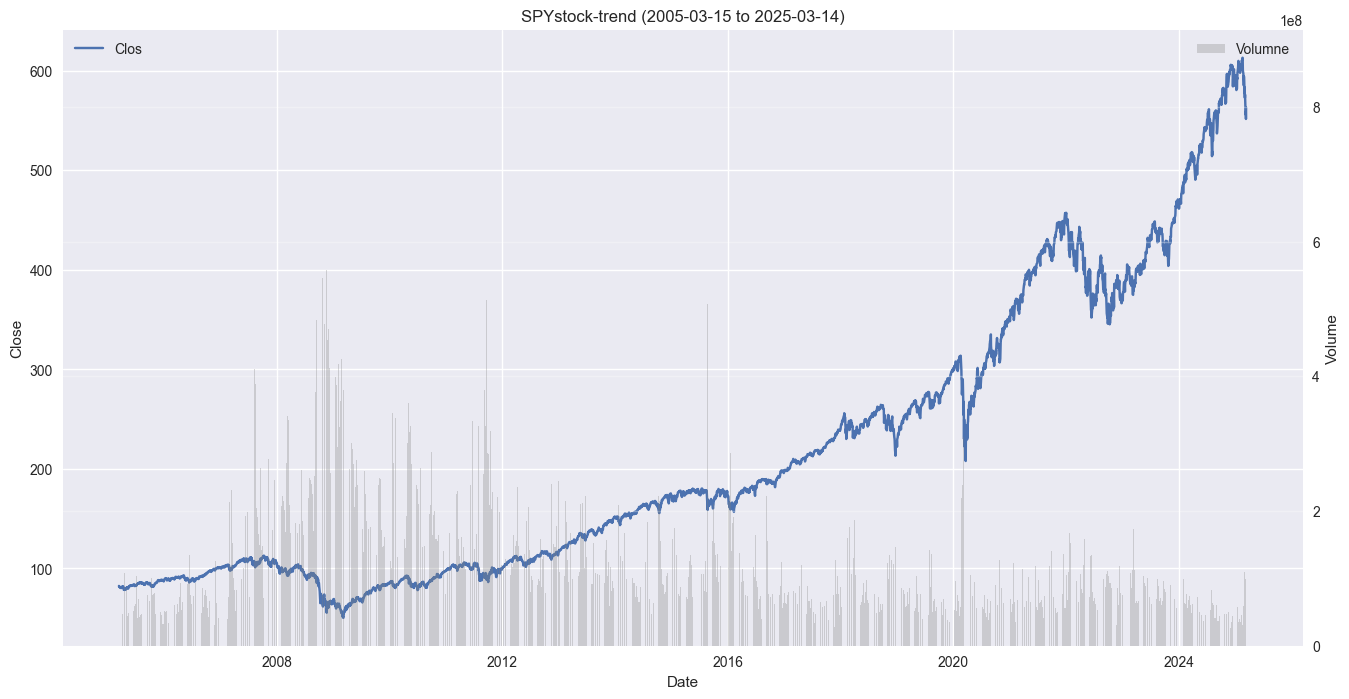

In [52]:
# Trend Visualize

start_date = stock_data.index[0]
end_date = stock_data.index[-1]

plt.figure(figsize=(16, 8))

plt.plot(stock_data.index, stock_data['Close'], label='Clos')

ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.bar(stock_data.index, stock_data['Volume'], alpha=0.3, color='gray', label='Volumne')
ax2.set_ylabel('Volume')

plt.title(f'{ticker_symbol}stock-trend ({start_date.date()} to {end_date.date()})')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.grid(True, alpha=0.3)
plt.show()


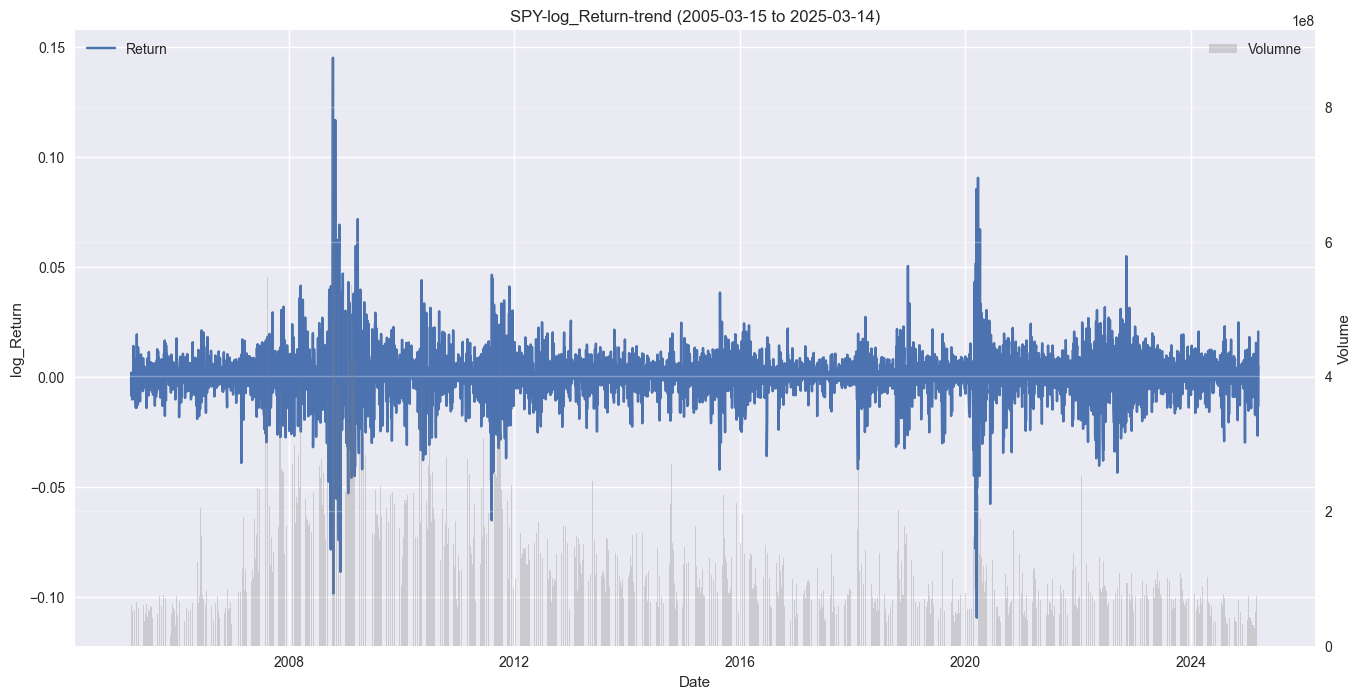

In [53]:
# Trend Visualize

start_date = stock_data.index[0]
end_date = stock_data.index[-1]

plt.figure(figsize=(16, 8))

plt.plot(stock_data.index, stock_data['log_Return'], label='Return')

ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.bar(stock_data.index, stock_data['Volume'], alpha=0.3, color='gray', label='Volumne')
ax2.set_ylabel('Volume')

plt.title(f'{ticker_symbol}-log_Return-trend ({start_date.date()} to {end_date.date()})')
ax1.set_xlabel('Date')
ax1.set_ylabel('log_Return')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.grid(True, alpha=0.3)
plt.show()


### Visualize Economic cycle and Partrition Training set and testing set

Acknowledgement: This assumption is pretty arguable, but at this point this is clearly not the main idea of this project.

We define the market to be bullish if the close price of SPY500 is higher than MA(200), bearish if lower.

In [54]:
def label_market_states(data, 
                       ma_window=200,  
                       bull_threshold=0.20, 
                       bear_threshold=-0.20,
                       hold_period=60):

    df = data.copy()
    
    # Basic Technical Index
    df['MA200'] = df['Close'].rolling(window=ma_window).mean()
    df['RollingMax'] = df['Close'].rolling(252, min_periods=1).max()
    df['RollingMin'] = df['Close'].rolling(252, min_periods=1).min()
    df['Drawdown'] = (df['Close'] - df['RollingMax']) / df['RollingMax']
    df['Rally'] = (df['Close'] - df['RollingMin']) / df['RollingMin']
    
    # Determine bull,bear,normal
    bull_cond = (df['Close'] > df['MA200']) & (df['Rally'] > bull_threshold)
    bear_cond = (df['Close'] < df['MA200']) & (df['Drawdown'] < bear_threshold)
    normal_cond = ~bull_cond & ~bear_cond
    
    # Label the Market condition
    df['Market_State'] = np.select(
        [bull_cond, bear_cond, normal_cond],
        ['bull', 'bear', 'normal'],
        default='normal'  
    )
    

    state_changes = df['Market_State'].ne(df['Market_State'].shift()).cumsum()
    state_durations = state_changes.groupby(state_changes).cumcount() + 1

    valid_states = (state_durations >= hold_period)
    df['Market_State'] = df['Market_State'].where(valid_states, np.nan)
    df['Market_State'] = df['Market_State'].ffill().bfill()  
    
    return df

full_data = label_market_states(stock_data)
print(full_data['Market_State'].value_counts())


Market_State
bull      2688
normal    2173
bear       172
Name: count, dtype: int64


In [55]:
def split_train_test(stock_data, 
                    train_start="2005-03-14", 
                    train_end="2020-03-14",  
                    test_start="2020-04-01"): 
    train_data = stock_data.loc[train_start:train_end]
    test_data = stock_data.loc[test_start:]
    return train_data, test_data


train_data, test_data = split_train_test(full_data)

In [56]:
train_data

Price,Close,High,Low,Open,Volume,log_Return,MA200,RollingMax,RollingMin,Drawdown,Rally,Market_State
Date,,,,,,,,,,,,
2005-03-15,82.454483,83.360425,82.413306,83.332972,62438500,0.000000,NaN,82.454483,82.454483,0.000000,0.000000,normal
2005-03-16,81.754471,82.468245,81.603480,82.152533,74874200,-0.008490,NaN,82.454483,81.754471,-0.008490,0.000000,normal
2005-03-17,81.919136,82.179936,81.658336,81.884818,62584200,0.002014,NaN,82.454483,81.754471,-0.006493,0.002014,normal
2005-03-18,81.675957,82.358081,81.407241,82.068696,60232000,-0.002969,NaN,82.454483,81.675957,-0.009442,0.000000,normal
2005-03-21,81.372757,81.841288,81.138494,81.793057,61244300,-0.003712,NaN,82.454483,81.372757,-0.013119,0.000000,normal
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-09,254.245346,263.479498,253.522190,255.237348,309417300,-0.078094,280.939847,313.683319,250.930267,-0.189484,0.013211,bull
2020-03-10,267.401184,267.493874,253.568478,263.896656,276444100,0.051745,280.987610,313.683319,250.930267,-0.147544,0.065639,bull
2020-03-11,254.365906,261.393526,251.139530,260.243901,255316300,-0.048748,280.967273,313.683319,250.930267,-0.189100,0.013692,bull


In [57]:
def split_market_states(train_data):
    return {
        'bull': train_data[train_data['Market_State'] == 'bull'],
        'bear': train_data[train_data['Market_State'] == 'bear'],
        'normal': train_data[train_data['Market_State'] == 'normal']
    }

In [58]:
market_states = split_market_states(train_data)

In [59]:
market_states

{'bull': Price            Close        High         Low        Open     Volume  \
 Date                                                                    
 2007-07-06  109.723267  109.859544  108.970163  109.292930   81109000   
 2007-07-09  109.809341  109.995820  109.465059  109.852374   72348100   
 2007-07-10  108.245758  109.457894  108.138177  109.228372  180362600   
 2007-07-11  109.013245  109.056277  107.958902  108.123864  175607600   
 2007-07-12  110.734604  110.992811  109.264261  109.285777  133882500   
 ...                ...         ...         ...         ...        ...   
 2020-03-09  254.245346  263.479498  253.522190  255.237348  309417300   
 2020-03-10  267.401184  267.493874  253.568478  263.896656  276444100   
 2020-03-11  254.365906  261.393526  251.139530  260.243901  255316300   
 2020-03-12  230.028870  247.227033  229.630199  237.343882  392220700   
 2020-03-13  249.693222  251.695815  230.409026  243.917225  329566100   
 
 Price       log_Return     

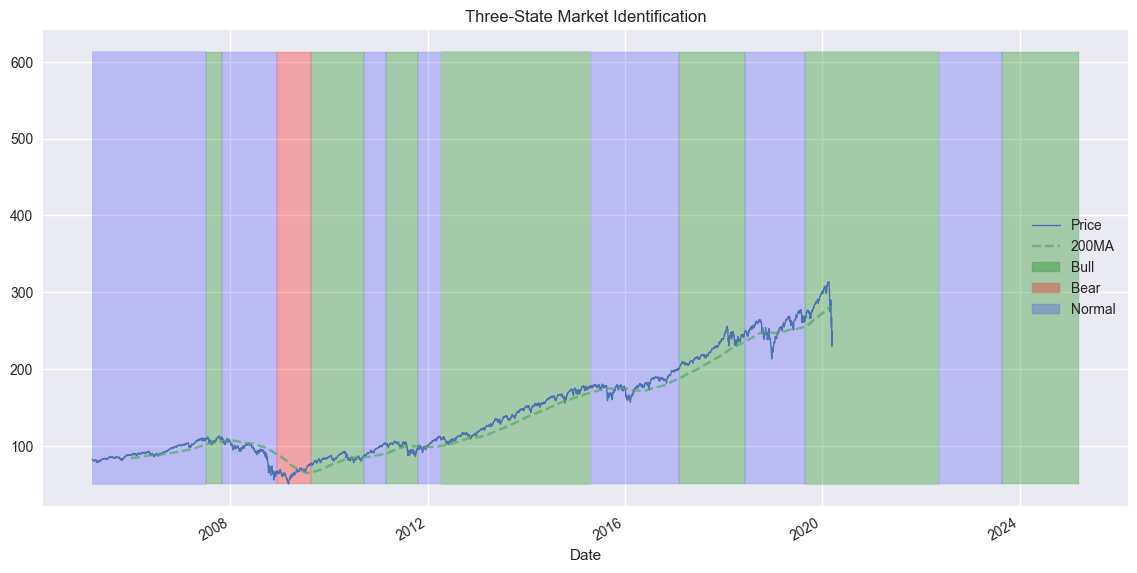

In [60]:
plt.figure(figsize=(14,7))
train_data['Close'].plot(label='Price', lw=1)
train_data['MA200'].plot(label='200MA', ls='--', alpha=0.7)


bull_mask = (full_data['Market_State'] == 'bull')
plt.fill_between(full_data.index, 
                full_data['Low'].min(), 
                full_data['High'].max(), 
                where=bull_mask, 
                color='Green', alpha=0.3, label='Bull')


bear_mask = (full_data['Market_State'] == 'bear')
plt.fill_between(full_data.index, 
                full_data['Low'].min(), 
                full_data['High'].max(), 
                where=bear_mask, 
                color='red', alpha=0.3, label='Bear')


normal_mask = (full_data['Market_State'] == 'normal')
plt.fill_between(full_data.index, 
                full_data['Low'].min(), 
                full_data['High'].max(), 
                where=normal_mask, 
                color='Blue', alpha=0.2, label='Normal')

plt.title("Three-State Market Identification")
plt.legend()
plt.show()

### Model Training

In [61]:
import DynamicQuKurt_strategy
import backtest

In [62]:
bull_data = train_data[train_data['Market_State'] == 'bull'].copy()
bear_data = train_data[train_data['Market_State'] == 'bear'].copy()
normal_data = train_data[train_data['Market_State'] == 'normal'].copy()

In [ ]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import t
import pandas as pd
import matplotlib.pyplot as plt

class TDistributionOptimizer:
    def __init__(self, lookback_period=252, default_p1=0.025, default_p2=0.25):
        self.lookback_period = lookback_period
        self.default_p1 = default_p1
        self.default_p2 = default_p2
        self.optimal_p1 = default_p1
        self.optimal_p2 = default_p2
        self.buy_threshold = 0.5  
        self.sell_threshold = 2.0

        self.optimization_path = {'p1': [], 'p2': []}

        
    def fit(self, returns):

        returns = np.array(returns[-self.lookback_period:])
        
        if len(returns) < self.lookback_period//2:
            return
        
  
        def neg_log_likelihood(params):
            p1, p2 = params
            if p1 >= p2 or p1 <= 0 or p2 >= 0.5:
                return np.inf
            try:
                qukurt = self.calculate_qukurt(returns, p1, p2)
                nu = self._fit_t_distribution(qukurt)
                return -np.sum(t.logpdf(returns, df=nu))
            except:
                return np.inf
        

        result = minimize(
            neg_log_likelihood,
            x0=[self.default_p1, self.default_p2],
            bounds=((0.01, 0.49), (0.05, 0.49))
        )
        
        if result.success:
            self.optimal_p1, self.optimal_p2 = result.x
            self._update_thresholds(returns)
            print(f"Optimized success: p1={self.optimal_p1:.3f}, p2={self.optimal_p2:.3f}")
        else:
            print("Optimized Fail")
        
    def _fit_t_distribution(self, target_qukurt):

        nu_range = np.linspace(2.0, 15.0, 130)
        qukurt_sim = []
        for nu in nu_range:
            sample = np.random.standard_t(nu, 1000)
            qukurt_sim.append(
                self.calculate_qukurt(sample, self.optimal_p1, self.optimal_p2)
            )
        return np.interp(target_qukurt, qukurt_sim, nu_range)
    
    def calculate_qukurt(self, returns, p1=None, p2=None):

        p1 = p1 or self.optimal_p1
        p2 = p2 or self.optimal_p2
        q_p1 = np.quantile(returns, p1)
        q_1mp1 = np.quantile(returns, 1-p1)
        q_p2 = np.quantile(returns, p2)
        q_1mp2 = np.quantile(returns, 1-p2)
        denominator = q_1mp2 - q_p2
        return (q_1mp1 - q_p1) / denominator if denominator != 0 else 0.0
    
    def _update_thresholds(self, returns):

        qukurt_series = [
            self.calculate_qukurt(returns[i-self.lookback_period:i]) 
            for i in range(self.lookback_period, len(returns))
        ]
        median_qukurt = np.median(qukurt_series)
        self.buy_threshold = median_qukurt / 1.5
        self.sell_threshold = median_qukurt * 1.5

In [ ]:
def compare_optimization(train_data):
    train_data = train_data.sort_index()
    train_data['log_Return'] = np.log(train_data['close'] / train_data['close'].shift(1))
    train_data.dropna(inplace=True)


    fixed_params_strat = TDistributionOptimizer()
    optimized_strat = TDistributionOptimizer()
    

    fixed_params_strat.buy_threshold = 0.4
    fixed_params_strat.sell_threshold = 1.8
    

    optimized_strat.fit(train_data['log_Return'])  
    

    def generate_signals(strat, data):
        signals = {'buy': [], 'sell': []}
        for i in range(len(data)):
            window = data['log_Return'].iloc[i-strat.lookback_period:i]
            qukurt = strat.calculate_qukurt(window)
            if qukurt < strat.buy_threshold:
                signals['buy'].append(data.index[i])
            elif qukurt > strat.sell_threshold:
                signals['sell'].append(data.index[i])
        return signals
    

    fixed_signals = generate_signals(fixed_params_strat, train_data)
    optimized_signals = generate_signals(optimized_strat, train_data)
    

    plt.figure(figsize=(14, 8))
    

    plt.subplot(2,1,1)
    plt.plot(train_data.index, train_data['price'], label='Price')
    plt.scatter(fixed_signals['buy'], train_data.loc[fixed_signals['buy'], 'price'], 
                marker='^', color='g', label='Fixed Buy')
    plt.scatter(fixed_signals['sell'], train_data.loc[fixed_signals['sell'], 'price'],
                marker='v', color='r', label='Fixed Sell')
    plt.title("Fixed Parameters Strategy Signals")
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(train_data.index, train_data['price'], label='Price')
    plt.scatter(optimized_signals['buy'], train_data.loc[optimized_signals['buy'], 'price'],
                marker='^', color='lime', label='Optimized Buy')
    plt.scatter(optimized_signals['sell'], train_data.loc[optimized_signals['sell'], 'price'],
                marker='v', color='darkred', label='Optimized Sell')
    plt.title("Optimized Parameters Strategy Signals")
    plt.legend()
    
    plt.tight_layout()
    

    metrics = pd.DataFrame({
        'Metric': ['Total Trades', 'Buy Signals', 'Sell Signals', 'Threshold Ratio'],
        'Fixed': [
            len(fixed_signals['buy']) + len(fixed_signals['sell']),
            len(fixed_signals['buy']),
            len(fixed_signals['sell']),
            f"{fixed_params_strat.sell_threshold/fixed_params_strat.buy_threshold:.1f}"
        ],
        'Optimized': [
            len(optimized_signals['buy']) + len(optimized_signals['sell']),
            len(optimized_signals['buy']),
            len(optimized_signals['sell']),
            f"{optimized_strat.sell_threshold/optimized_strat.buy_threshold:.1f}"
        ]
    }).set_index('Metric')
    
    print("\nStrategy Comparison:")
    print(metrics)
    

    if hasattr(optimized_strat, 'optimization_path'):
        plt.figure(figsize=(12,6))
        plt.plot(optimized_strat.optimization_path['p1'], label='p1')
        plt.plot(optimized_strat.optimization_path['p2'], label='p2')
        plt.title("Parameter Optimization Trajectory")
        plt.xlabel("Optimization Step")
        plt.ylabel("Parameter Value")
        plt.legend()
        plt.grid(True)


In [65]:

import numpy as np
import pandas as pd
import itertools
from typing import Tuple, List

In [66]:
np.random.seed(42)

N = 1000  # total sample size
dates = pd.date_range(start='2020-01-01', periods=N, freq='B')  # business days

# Create some random returns
returns_data = np.random.normal(loc=0.0005, scale=0.01, size=N)  # daily returns

# For demonstration, let's randomly label "bull", "bear", "normal"
states = np.random.choice(["bull", "bear", "normal"], size=N, p=[0.3, 0.3, 0.4])

# Combine into a DataFrame
df = pd.DataFrame({
    "Date": dates,
    "Returns": returns_data,
    "Market_State": states
}).set_index("Date")

df.head()

,Returns,Market_State
Date,,
2020-01-01,0.005467,bull
2020-01-02,-0.000883,bull
2020-01-03,0.006977,normal
2020-01-06,0.015730,normal
2020-01-07,-0.001842,bull


In [67]:
def calc_quKurt(returns: np.ndarray, p1: float = 0.025, p2: float = 0.25) -> float:
    """
    Calculates a simple quantile-based kurtosis (quKurt) factor:
    
        quKurt = (q_{1-p1} - q_{p1}) / (q_{1-p2} - q_{p2})
    
    Args:
        returns (np.ndarray): 1D array of returns (any time window).
        p1 (float): lower-tail quantile probability
        p2 (float): mid-range quantile probability (p1 < p2 < 0.5)
    
    Returns:
        float: quKurt value. If denominator is zero or invalid, returns np.nan.
    """
    if len(returns) < 5:
        return np.nan  # not enough data

    if p1 <= 0 or p2 <= p1 or p2 >= 0.5:
        return np.nan  # invalid parameter setting
    
    q_p1 = np.quantile(returns, p1)
    q_1mp1 = np.quantile(returns, 1 - p1)
    
    q_p2 = np.quantile(returns, p2)
    q_1mp2 = np.quantile(returns, 1 - p2)
    
    denominator = (q_1mp2 - q_p2)
    if denominator == 0:
        return np.nan
    
    qukurt_val = (q_1mp1 - q_p1) / denominator
    return qukurt_val



In [68]:

def evaluate_quKurt_in_market_states(
    data: pd.DataFrame, 
    p1: float, 
    p2: float, 
    window: int = 126
) -> pd.DataFrame:
    """
    Compute quKurt factor in a rolling manner for each row in `data`,
    grouped by 'Market_State' label. (Simplistic example).
    
    Args:
        data (pd.DataFrame): Must contain columns ['Returns', 'Market_State'].
        p1, p2 (float): parameters for quKurt
        window (int): rolling window size
    
    Returns:
        pd.DataFrame: Original data plus a new 'quKurt' column.
    """
    data = data.copy()
    data["quKurt"] = np.nan
    
    # Rolling approach (naive example)
    for i in range(len(data)):
        if i < window:
            continue
        rolling_returns = data["log_Return"].iloc[i-window:i].values
        qk_val = calc_quKurt(rolling_returns, p1, p2)
        data.iloc[i, data.columns.get_loc("quKurt")] = qk_val
    
    return data

In [72]:
bull_with_qukurt = evaluate_quKurt_in_market_states(bull_data, 0.025, 0.25)
bear_with_qukurt = evaluate_quKurt_in_market_states(bear_data, 0.025, 0.25)
normal_with_qukurt = evaluate_quKurt_in_market_states(normal_data, 0.025, 0.25)

In [102]:
bull_with_qukurt.fillna(0)

Price,Close,High,Low,Open,Volume,log_Return,MA200,RollingMax,RollingMin,Drawdown,Rally,Market_State,quKurt
Date,,,,,,,,,,,,,
2007-07-06,109.723267,109.859544,108.970163,109.292930,81109000,0.005257,102.066088,110.052238,86.868492,-0.002989,0.263096,bull,0.000000
2007-07-09,109.809341,109.995820,109.465059,109.852374,72348100,0.000784,102.148924,110.052238,86.868492,-0.002207,0.264087,bull,0.000000
2007-07-10,108.245758,109.457894,108.138177,109.228372,180362600,-0.014239,102.221466,110.052238,86.868492,-0.016415,0.246088,bull,0.000000
2007-07-11,109.013245,109.056277,107.958902,108.123864,175607600,0.007090,102.300109,110.052238,86.868492,-0.009441,0.254923,bull,0.000000
2007-07-12,110.734604,110.992811,109.264261,109.285777,133882500,0.015790,102.388773,110.734604,86.868492,0.000000,0.274738,bull,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-09,254.245346,263.479498,253.522190,255.237348,309417300,-0.078094,280.939847,313.683319,250.930267,-0.189484,0.013211,bull,5.702617
2020-03-10,267.401184,267.493874,253.568478,263.896656,276444100,0.051745,280.987610,313.683319,250.930267,-0.147544,0.065639,bull,5.923265
2020-03-11,254.365906,261.393526,251.139530,260.243901,255316300,-0.048748,280.967273,313.683319,250.930267,-0.189100,0.013692,bull,5.816683


In [73]:
def get_qukurt_array(df):
    """
    Extracts the quKurt column, drops NaN, returns a 1D numpy array.
    """
    return df['quKurt'].dropna().values

bull_qk = get_qukurt_array(bull_with_qukurt)
bear_qk = get_qukurt_array(bear_with_qukurt)
normal_qk = get_qukurt_array(normal_with_qukurt)


In [74]:
def neg_log_likelihood_t(params, data):
    """
    Negative log-likelihood for the Student's t distribution.
    
    params: (nu, loc, scale)
    data: 1D array of observations
    """
    nu, loc, scale = params
    
    # Enforce positivity constraints
    if scale <= 0 or nu <= 2:
        return np.inf  # invalid domain => large penalty
    
    # - sum of log t.pdf
    nll = -np.sum(t.logpdf(data, df=nu, loc=loc, scale=scale))
    return nll


In [75]:
def fit_t_distribution_mle(data, init_params=(5.0, 0.0, 1.0)):
    """
    Fits t-dist to data using MLE for (nu, loc, scale).
    Returns (nu_hat, loc_hat, scale_hat, success_flag, result_object).
    """
    bounds = ((2.001, 50.0),   # nu in [>2, 50], adjust as needed
              (-10.0, 10.0),  # loc in [-10, 10], or widen if needed
              (1e-5, 10.0))   # scale in (0, 10]
    
    result = minimize(
        neg_log_likelihood_t, 
        x0=init_params, 
        args=(data,),
        bounds=bounds, 
        method='L-BFGS-B'
    )
    
    if result.success:
        nu_hat, loc_hat, scale_hat = result.x
        return nu_hat, loc_hat, scale_hat, True, result
    else:
        return None, None, None, False, result

In [76]:
def analyze_qukurt_tfit(name, data):
    """
    1) Fit t-dist MLE
    2) Print results
    3) Plot histogram + fitted PDF
    """
    if len(data) < 30:
        print(f"[{name}] Not enough data to fit: only {len(data)} points.")
        return
    
    nu_hat, loc_hat, scale_hat, success, res_obj = fit_t_distribution_mle(data)
    
    if not success:
        print(f"[{name}] MLE optimization failed. Info:", res_obj)
        return
    
    print(f"[{name}] Fitted t-dist params => nu={nu_hat:.3f}, loc={loc_hat:.3f}, scale={scale_hat:.3f}")
    print(f" Final negative log-likelihood = {res_obj.fun:.3f}")
    
    # Plot
    plt.figure(figsize=(7,4))
    plt.hist(data, bins=30, density=True, alpha=0.5, label=f"{name} quKurt hist")
    
    # Overplot t-distribution PDF
    xs = np.linspace(min(data), max(data), 200)
    pdf_vals = t.pdf(xs, df=nu_hat, loc=loc_hat, scale=scale_hat)
    plt.plot(xs, pdf_vals, 'r-', label='Fitted t PDF')
    
    plt.title(f"quKurt Distribution in {name} State (t-dist fitted)")
    plt.legend()
    plt.show()



# Trained Bull Market Data

[Bull] Fitted t-dist params => nu=23.464, loc=3.926, scale=0.748
 Final negative log-likelihood = 1907.223


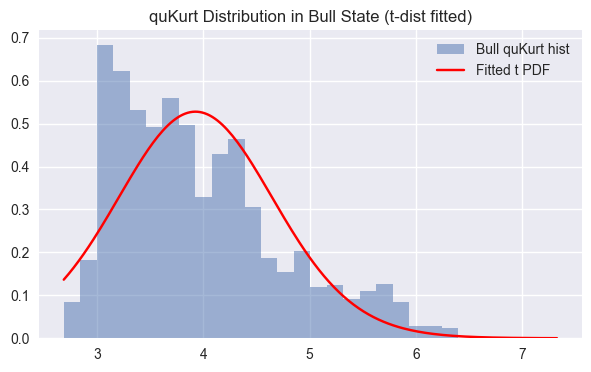

In [77]:
analyze_qukurt_tfit("Bull", bull_qk)

In [78]:
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy import stats

In [79]:
def fit_t_via_scipy(data):
    """
    Fit a Student's t-dist to `data` via:
    stats.t.fit => returns (df, loc, scale).
    
    - df (degrees of freedom)
    - loc (location)
    - scale
    """
    if len(data) < 2:
        return None, None, None
    # stats.t.fit uses MLE under the hood
    df_hat, loc_hat, scale_hat = stats.t.fit(data, floc=0)  
    return df_hat, loc_hat, scale_hat

In [80]:

def analyze_with_statsmodels(name, data):
    """
    1) Fit the data to a t-dist (df, loc, scale).
    2) Show QQ plot with statsmodels to see how well 
       the fitted t-dist matches the empirical distribution.
    """
    if len(data) < 10:
        print(f"[{name}] Not enough data to analyze (n={len(data)})")
        return

    # A. Fit using scipy.stats.t.fit
    df_hat, loc_hat, scale_hat = fit_t_via_scipy(data)
    print(f"[{name}] => Fitted (df={df_hat:.3f}, loc={loc_hat:.3f}, scale={scale_hat:.3f})")

    # B. QQ Plot with Statsmodels
    # We'll define a "frozen" T-distribution using the fitted parameters
    t_dist_frozen = stats.t(df=df_hat, loc=loc_hat, scale=scale_hat)

    fig = sm.qqplot(
        data,
        dist=t_dist_frozen,   # pass the "frozen" distribution
        line='45',
        fit=False             # if True, statsmodels tries to fit again, we already have parameters
    )
    fig.suptitle(f"QQ Plot of quKurt in {name} State vs. Fitted t-dist")
    plt.show()


[Bull] => Fitted (df=44186747777241.500, loc=0.000, scale=4.029)


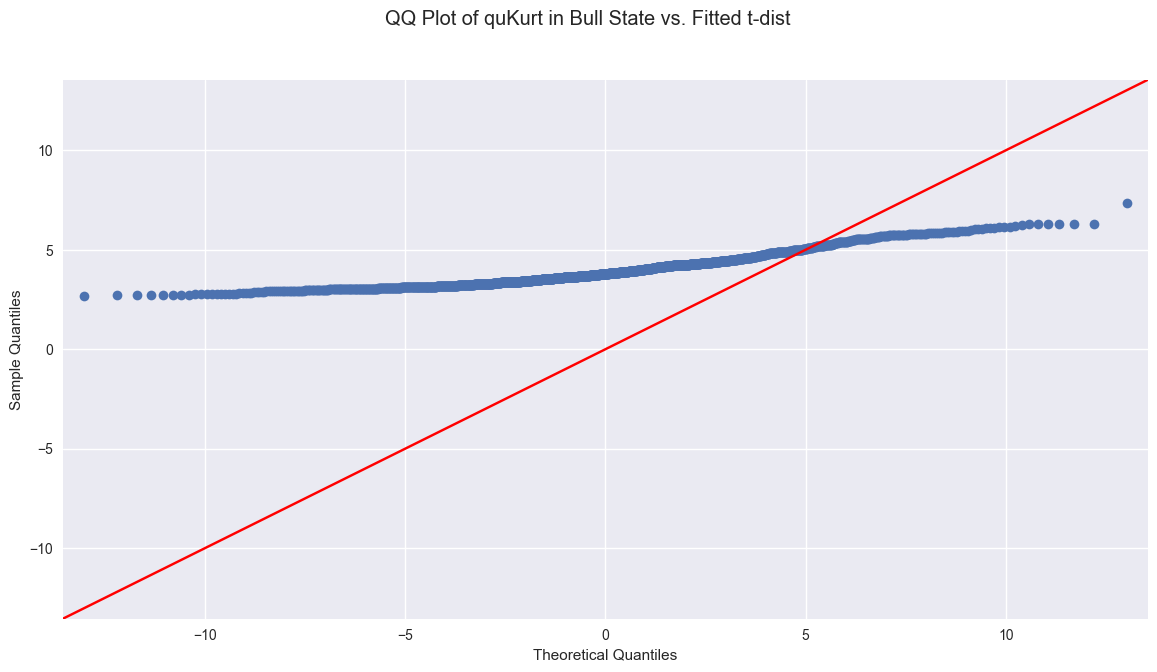

In [81]:
analyze_with_statsmodels("Bull", bull_qk)

In [86]:
from statsmodels.base.model import GenericLikelihoodModel
from scipy import stats
import matplotlib.pyplot as plt

In [87]:
class TDistModel(GenericLikelihoodModel):
    """
    Custom Statsmodels class to fit a t-distribution to 1D data (endog).
    We estimate three parameters: (nu, loc, scale).
    """

    def nloglikeobs(self, params):
        """
        Negative log-likelihood of the t-distribution for each observation.
        params = [nu, loc, scale]
        """
        nu, loc, scale = params

        # Enforce constraints:
        #   nu > 2   (heavy tails possible, but not indefinite)
        #   scale > 0
        if nu <= 2 or scale <= 0:
            # Return a large penalty so optimizer won't go there
            return 1e10 * np.ones_like(self.endog)

        # Evaluate logpdf
        logpdf_vals = stats.t.logpdf(self.endog, df=nu, loc=loc, scale=scale)
        return -logpdf_vals  # negative log-likelihood

    def fit(self, start_params=None, maxiter=2000, maxfun=2000, **kwds):
        """
        Fit the model using BFGS by default.
        Provide a decent start_params to help convergence.
        """
        if start_params is None:
            # Provide some default guesses: (nu, loc, scale)
            # E.g. (df=5, loc=mean, scale=std)
            loc_guess = np.mean(self.endog)
            scale_guess = np.std(self.endog) if np.std(self.endog) > 0 else 1.0
            start_params = [5.0, loc_guess, scale_guess]

        return super(TDistModel, self).fit(
            start_params=start_params,
            maxiter=maxiter, maxfun=maxfun, **kwds
        )

    def predict(self, params, exog=None):
        """
        Return the *CDF* evaluated at each observed data point in self.endog.
        This is so we can compare empirical CDF vs. fitted (theoretical) CDF.
        """
        nu, loc, scale = params
        # In principle, you can pass exog if you had a regression-like approach,
        # but for pure distribution fitting, we'll use self.endog.
        return stats.t.cdf(self.endog, df=nu, loc=loc, scale=scale)


In [88]:
def cdf_mse_r2(model, result):
    """
    1) Sort the data in ascending order => x_sorted
    2) Build empirical CDF => ecdf_vals
    3) Evaluate fitted T-dist's CDF => predicted_cdf_vals
       (We can do this by re-running stats.t.cdf(...) on x_sorted 
        using the fit parameters from result)
    4) MSE = mean((ecdf_vals - predicted_cdf_vals)^2)
    5) R^2 = 1 - SS_res / SS_tot, 
             where SS_res = sum of residual^2,
                   SS_tot = sum((ecdf_vals - mean(ecdf_vals))^2)
    """
    # 0) Extract best-fit params
    nu_hat, loc_hat, scale_hat = result.params

    # 1) Sort the data
    data_sorted = np.sort(model.endog)  # model.endog is the original data
    n = len(data_sorted)

    # 2) Empirical CDF
    #    ecdf(i-th sorted value) ~ (i)/(n+1), or something close
    ranks = np.arange(1, n+1)
    ecdf_vals = ranks / (n+1.0)

    # 3) Predicted T-dist CDF at each x_{(i)}
    pred_cdf_vals = stats.t.cdf(data_sorted, df=nu_hat, loc=loc_hat, scale=scale_hat)

    # 4) MSE
    residuals = ecdf_vals - pred_cdf_vals
    mse = np.mean(residuals**2)

    # 5) pseudo-R^2
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ecdf_vals - np.mean(ecdf_vals))**2)
    r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan

    return mse, r2

In [89]:
model_bull = TDistModel(bull_qk)

In [90]:
results_bull = model_bull.fit(method='bfgs', disp=False)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: maxfun. After release 0.14, this will raise.
  warnings.warn(


In [91]:
print(results_bull.summary())

                              TDistModel Results                              
Dep. Variable:                      y   Log-Likelihood:                -1907.2
Model:                     TDistModel   AIC:                             3826.
Method:            Maximum Likelihood   BIC:                             3859.
Date:                Fri, 14 Mar 2025                                         
Time:                        22:52:08                                         
No. Observations:                1628                                         
Df Residuals:                    1625                                         
Df Model:                           3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
par0          23.4860     14.204      1.654      0.098      -4.353      51.325
par1           3.9263      0.024    161.944      0.0

In [92]:
# 3) Evaluate MSE, R^2
mse_bull, r2_bull = cdf_mse_r2(model_bull, results_bull)

print(f"== Bull State Model Fit ==")
print(f"  MSE (CDF) = {mse_bull:.6f}")
print(f"  R^2 (CDF) = {r2_bull:.3f}")

== Bull State Model Fit ==
  MSE (CDF) = 0.002134
  R^2 (CDF) = 0.974


# Dynamic Signal

\begin{equation}
\kappa_L \;=\;
\hat{\theta}_n \;+\; \frac{q_{\alpha/2}^*}{\sqrt{n}},
\quad\quad
\kappa_U \;=\;
\hat{\theta}_n \;+\; \frac{q_{1-\alpha/2}^*}{\sqrt{n}}.
\end{equation}

## Bull Market Apply

In [109]:

bull_with_qukurt["theta_hat"] = (
    bull_with_qukurt["quKurt"]
    .rolling(window=126, min_periods=126)
    .mean()
)
bull_with_qukurt= bull_with_qukurt.fillna(0)
bull_with_qukurt["n"] = np.arange(len(bull_with_qukurt)) + 1

bull_with_qukurt

Price,Close,High,Low,Open,Volume,log_Return,MA200,RollingMax,RollingMin,Drawdown,Rally,Market_State,quKurt,theta_hat,n
Date,,,,,,,,,,,,,,,
2007-07-06,109.723267,109.859544,108.970163,109.292930,81109000,0.005257,102.066088,110.052238,86.868492,-0.002989,0.263096,bull,0.000000,0.000000,1
2007-07-09,109.809341,109.995820,109.465059,109.852374,72348100,0.000784,102.148924,110.052238,86.868492,-0.002207,0.264087,bull,0.000000,0.000000,2
2007-07-10,108.245758,109.457894,108.138177,109.228372,180362600,-0.014239,102.221466,110.052238,86.868492,-0.016415,0.246088,bull,0.000000,0.000000,3
2007-07-11,109.013245,109.056277,107.958902,108.123864,175607600,0.007090,102.300109,110.052238,86.868492,-0.009441,0.254923,bull,0.000000,0.000000,4
2007-07-12,110.734604,110.992811,109.264261,109.285777,133882500,0.015790,102.388773,110.734604,86.868492,0.000000,0.274738,bull,0.000000,0.000000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-09,254.245346,263.479498,253.522190,255.237348,309417300,-0.078094,280.939847,313.683319,250.930267,-0.189484,0.013211,bull,5.702617,3.507844,1750
2020-03-10,267.401184,267.493874,253.568478,263.896656,276444100,0.051745,280.987610,313.683319,250.930267,-0.147544,0.065639,bull,5.923265,3.526724,1751
2020-03-11,254.365906,261.393526,251.139530,260.243901,255316300,-0.048748,280.967273,313.683319,250.930267,-0.189100,0.013692,bull,5.816683,3.544758,1752


In [110]:
def apply_kappa_thresholds(df,
                           qukurt_col='quKurt',
                           theta_col='theta_hat',
                           q_lower=-2.0,
                           q_upper=+2.0,
                           alpha=0.05):
    """
    A simple example of using eq. (5) to define kappa_L, kappa_U,
    then generate trading signals:
      +1 => quKurt > kappa_U  (Buy)
      -1 => quKurt < kappa_L  (Sell)
       0 => Otherwise

    df must contain:
      - df[qukurt_col]: the current quKurt estimate
      - df[theta_col]: the 'hat(theta)_n' baseline
      - df['n']: the sample size or scaling factor for eq. (5)
    
    Args:
        q_lower, q_upper: placeholders for q_{\alpha/2}^*, q_{1-\alpha/2}^*.
        (In practice these come from a bootstrap or t-dist distribution.)
        alpha: significance level (not used directly in code, but for clarity)
    """
    df = df.copy()
    
    # 1) compute kappa_L, kappa_U via eqn (5)
    df['kappa_L'] = df[theta_col] + (q_lower / np.sqrt(df['n']))
    df['kappa_U'] = df[theta_col] + (q_upper / np.sqrt(df['n']))
    
    # 2) define signals
    df['signal'] = 0
    buy_mask  = df[qukurt_col] > df['kappa_U']
    sell_mask = df[qukurt_col] < df['kappa_L']
    
    df.loc[buy_mask,  'signal'] = +1
    df.loc[sell_mask, 'signal'] = -1
    
    return df


In [112]:
bull_signal = apply_kappa_thresholds(
    bull_with_qukurt,
    qukurt_col="quKurt", 
    theta_col="theta_hat",
    q_lower=-2.0,   # example stand-ins for q_{\alpha/2}^*, q_{1-\alpha/2}^*
    q_upper=+2.0,
    alpha=0.05
)
bull_signal

Price,Close,High,Low,Open,Volume,log_Return,MA200,RollingMax,RollingMin,Drawdown,Rally,Market_State,quKurt,theta_hat,n,kappa_L,kappa_U,signal
Date,,,,,,,,,,,,,,,,,,
2007-07-06,109.723267,109.859544,108.970163,109.292930,81109000,0.005257,102.066088,110.052238,86.868492,-0.002989,0.263096,bull,0.000000,0.000000,1,-2.000000,2.000000,0
2007-07-09,109.809341,109.995820,109.465059,109.852374,72348100,0.000784,102.148924,110.052238,86.868492,-0.002207,0.264087,bull,0.000000,0.000000,2,-1.414214,1.414214,0
2007-07-10,108.245758,109.457894,108.138177,109.228372,180362600,-0.014239,102.221466,110.052238,86.868492,-0.016415,0.246088,bull,0.000000,0.000000,3,-1.154701,1.154701,0
2007-07-11,109.013245,109.056277,107.958902,108.123864,175607600,0.007090,102.300109,110.052238,86.868492,-0.009441,0.254923,bull,0.000000,0.000000,4,-1.000000,1.000000,0
2007-07-12,110.734604,110.992811,109.264261,109.285777,133882500,0.015790,102.388773,110.734604,86.868492,0.000000,0.274738,bull,0.000000,0.000000,5,-0.894427,0.894427,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-09,254.245346,263.479498,253.522190,255.237348,309417300,-0.078094,280.939847,313.683319,250.930267,-0.189484,0.013211,bull,5.702617,3.507844,1750,3.460035,3.555654,1
2020-03-10,267.401184,267.493874,253.568478,263.896656,276444100,0.051745,280.987610,313.683319,250.930267,-0.147544,0.065639,bull,5.923265,3.526724,1751,3.478929,3.574520,1
2020-03-11,254.365906,261.393526,251.139530,260.243901,255316300,-0.048748,280.967273,313.683319,250.930267,-0.189100,0.013692,bull,5.816683,3.544758,1752,3.496976,3.592540,1


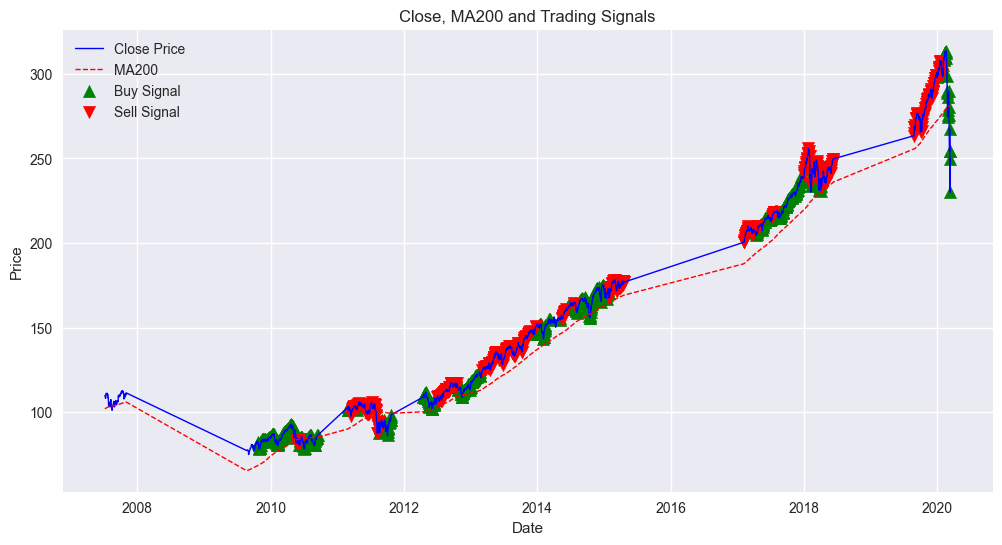

In [ ]:
def plot_bull_signal(bull_signal):
    plt.figure(figsize=(12, 6))


    plt.plot(bull_signal.index, 
             bull_signal['Close'], 
             label='Close Price', 
             color='blue', 
             linewidth=1)


    plt.plot(bull_signal.index, 
             bull_signal['MA200'], 
             label='MA200', 
             color='red', 
             linestyle='--', 
             linewidth=1)


    buy_signals = bull_signal[bull_signal['signal'] == 1]
    plt.scatter(buy_signals.index, 
                buy_signals['Close'], 
                marker='^', 
                color='green', 
                s=80, 
                label='Buy Signal')


    sell_signals = bull_signal[bull_signal['signal'] == -1]
    plt.scatter(sell_signals.index, 
                sell_signals['Close'], 
                marker='v', 
                color='red', 
                s=80, 
                label='Sell Signal')

    plt.title('Close, MA200 and Trading Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_bull_signal(bull_signal)


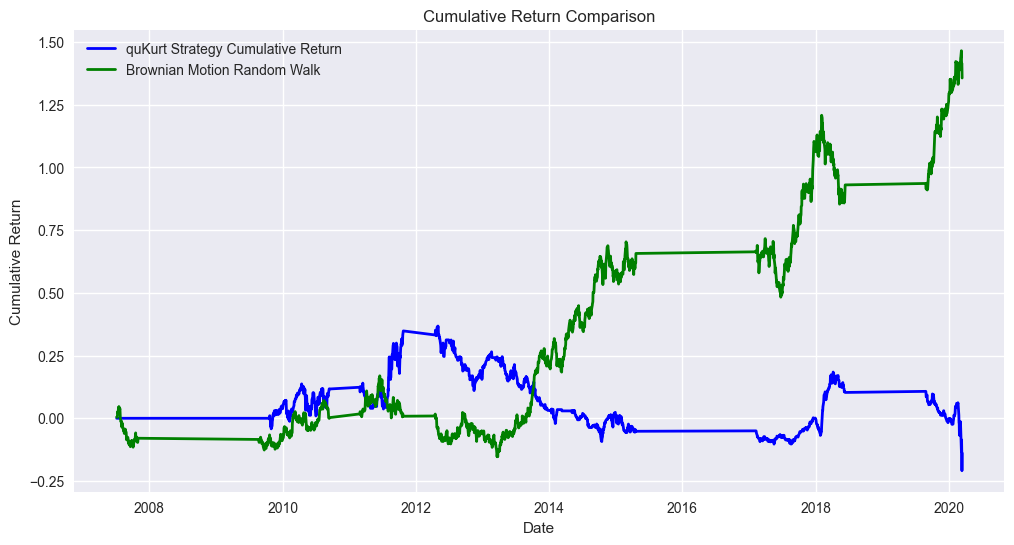

In [130]:
def plot_cumulative_returns_vs_random_walk(bull_signal):
    strategy_log_ret = bull_signal['signal'] * bull_signal['log_Return']
    
    strategy_cum_log_ret = strategy_log_ret.cumsum()
    strategy_cum_ret = np.exp(strategy_cum_log_ret) - 1

    n = len(bull_signal)
    np.random.seed(42)  
    random_log_returns = np.random.normal(loc=0.0, scale=0.01, size=n)
    

    random_cum_log_ret = np.cumsum(random_log_returns)

    random_cum_ret = np.exp(random_cum_log_ret) - 1


    plt.figure(figsize=(12, 6))


    plt.plot(bull_signal.index, strategy_cum_ret, 
             label='quKurt Strategy Cumulative Return', color='blue', linewidth=2)

    plt.plot(bull_signal.index, random_cum_ret, 
             label='Brownian Motion Random Walk', color='green', linewidth=2)

    plt.title('Cumulative Return Comparison')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_cumulative_returns_vs_random_walk(bull_signal)

In [ ]:
valid_data = bull_signal.dropna()

valid_data['Market_Return'] = bull_signal['Close'].pct_change()

valid_data['Trade_Signal'] = bull_signal['signal'].shift(1)

valid_data = valid_data.fillna(0)
valid_data



Price,Close,High,Low,Open,Volume,log_Return,MA200,RollingMax,RollingMin,Drawdown,Rally,Market_State,quKurt,theta_hat,n,kappa_L,kappa_U,signal,Market_Return,Trade_Signal
Date,,,,,,,,,,,,,,,,,,,,
2007-07-06,109.723267,109.859544,108.970163,109.292930,81109000,0.005257,102.066088,110.052238,86.868492,-0.002989,0.263096,bull,0.000000,0.000000,1,-2.000000,2.000000,0,0.000000,0.0
2007-07-09,109.809341,109.995820,109.465059,109.852374,72348100,0.000784,102.148924,110.052238,86.868492,-0.002207,0.264087,bull,0.000000,0.000000,2,-1.414214,1.414214,0,0.000784,0.0
2007-07-10,108.245758,109.457894,108.138177,109.228372,180362600,-0.014239,102.221466,110.052238,86.868492,-0.016415,0.246088,bull,0.000000,0.000000,3,-1.154701,1.154701,0,-0.014239,0.0
2007-07-11,109.013245,109.056277,107.958902,108.123864,175607600,0.007090,102.300109,110.052238,86.868492,-0.009441,0.254923,bull,0.000000,0.000000,4,-1.000000,1.000000,0,0.007090,0.0
2007-07-12,110.734604,110.992811,109.264261,109.285777,133882500,0.015790,102.388773,110.734604,86.868492,0.000000,0.274738,bull,0.000000,0.000000,5,-0.894427,0.894427,0,0.015790,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-09,254.245346,263.479498,253.522190,255.237348,309417300,-0.078094,280.939847,313.683319,250.930267,-0.189484,0.013211,bull,5.702617,3.507844,1750,3.460035,3.555654,1,-0.078094,1.0
2020-03-10,267.401184,267.493874,253.568478,263.896656,276444100,0.051745,280.987610,313.683319,250.930267,-0.147544,0.065639,bull,5.923265,3.526724,1751,3.478929,3.574520,1,0.051745,1.0
2020-03-11,254.365906,261.393526,251.139530,260.243901,255316300,-0.048748,280.967273,313.683319,250.930267,-0.189100,0.013692,bull,5.816683,3.544758,1752,3.496976,3.592540,1,-0.048748,1.0


In [129]:

valid_data['Position_Change'] = valid_data['Trade_Signal'].diff().abs()

transaction_cost = 0.001

valid_data['Strategy_Return'] = valid_data['Trade_Signal'] * valid_data['Market_Return'] - transaction_cost * valid_data['Position_Change']

valid_data['Cumulative_Market'] = (1 + valid_data['Market_Return'].fillna(0)).cumprod()
valid_data['Cumulative_Strategy'] = (1 + valid_data['Strategy_Return'].fillna(0)).cumprod()

total_days = (valid_data.index[-1] - valid_data.index[0]).days
annual_return_strategy = (valid_data['Cumulative_Strategy'].iloc[-1] ** (365 / total_days)) - 1
annual_return_market = (valid_data['Cumulative_Market'].iloc[-1] ** (365 / total_days)) - 1


daily_vol_strategy = valid_data['Strategy_Return'].std()
annual_vol_strategy = daily_vol_strategy * np.sqrt(252)  

daily_vol_market = valid_data['Market_Return'].std()  
annual_vol_market = daily_vol_market * np.sqrt(252)

sharpe_ratio_strategy = annual_return_strategy / annual_vol_strategy
sharpe_ratio_market = annual_return_market / annual_vol_market


cumulative_returns_strategy = valid_data['Cumulative_Strategy']
running_max_strategy = cumulative_returns_strategy.cummax()
drawdown_strategy = (cumulative_returns_strategy - running_max_strategy) / running_max_strategy
max_drawdown_strategy = drawdown_strategy.min()

cumulative_returns_market = valid_data['Cumulative_Market']
running_max_market = cumulative_returns_market.cummax()
drawdown_market = (cumulative_returns_market - running_max_market) / running_max_market
max_drawdown_market = drawdown_market.min()


print(f"Date Length: {valid_data.index[0].date()} to {valid_data.index[-1].date()}")
print(f"Total tday: {len(valid_data)}")
print("\n--- Strategy statistics ---")
print(f"Annual Return: {annual_return_strategy:.2%}")
print(f"Annual Volatlity: {annual_vol_strategy:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_strategy:.2f}")
print(f"MDD: {max_drawdown_strategy:.2%}")
print("\n--- Benchmark Testing (Buy & Hold) ---")
print(f"Annual Return: {annual_return_market:.2%}")
print(f"Annual Volatility: {annual_vol_market:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_market:.2f}")
print(f"MDD: {max_drawdown_market:.2%}")


Date Length: 2007-07-06 to 2020-03-13
Total tday: 1754

--- Strategy statistics ---
Annual Return: -0.56%
Annual Volatlity: 18.23%
Sharpe Ratio: -0.03
MDD: -52.28%

--- Benchmark Testing (Buy & Hold) ---
Annual Return: 6.69%
Annual Volatility: 22.43%
Sharpe Ratio: 0.30
MDD: -33.48%


In [ ]:
def add_bollinger_style_qukurt(
    df: pd.DataFrame,
    qukurt_col: str = "quKurt",
    window: int = 126,
    k: float = 2.0,
    min_periods: int = None
) -> pd.DataFrame:
    """
    Create a dynamic threshold for quKurt using a rolling mean +/- k*rolling_std.
    This is analogous to Bollinger Bands, but applied to the quKurt series.

    Args:
        df (pd.DataFrame): Must contain quKurt_col with quKurt values.
        qukurt_col (str): Column name of quKurt.
        window (int): Rolling window size (e.g. 252 for ~1 year).
        k (float): Multiplier for the rolling std (like Bollinger k=2).
        min_periods (int): Minimum periods for the rolling calculations. 
                           If None, defaults to 'window'.

    Returns:
        pd.DataFrame: A copy of df with new columns:
          "quKurt_mean", "quKurt_std", "quKurt_upper", "quKurt_lower", "signal"
    """
    if min_periods is None:
        min_periods = window
    
    df = df.copy()
    # 1) Rolling mean and std
    df["quKurt_mean"] = (
        df[qukurt_col]
        .rolling(window=window, min_periods=min_periods)
        .mean()
    )
    df["quKurt_std"] = (
        df[qukurt_col]
        .rolling(window=window, min_periods=min_periods)
        .std()
    )
    
    # 2) Upper / Lower bands
    df["quKurt_upper"] = df["quKurt_mean"] + k * df["quKurt_std"]
    df["quKurt_lower"] = df["quKurt_mean"] - k * df["quKurt_std"]
    
    # 3) A naive signal
    #    +1 if quKurt < quKurt_lower (below lower band)
    #    -1 if quKurt > quKurt_upper (above upper band)
    #     0 otherwise
    df["signal"] = 0
    mask_buy  = (df[qukurt_col] < df["quKurt_lower"]) & df["quKurt_lower"].notna()
    mask_sell = (df[qukurt_col] > df["quKurt_upper"]) & df["quKurt_upper"].notna()
    df.loc[mask_buy,  "signal"] = +1
    df.loc[mask_sell, "signal"] = -1

    return df

In [ ]:
# In[2]: Example function to add dynamic thresholds & signals
def add_dynamic_qukurt_thresholds(
    df: pd.DataFrame,
    qukurt_col: str = "quKurt",
    window: int = 126,
    threshold_multiplier: float = 1.5,
    min_periods: int = None
) -> pd.DataFrame:
    """
    Create a rolling-based threshold around quKurt. For instance:
      - rolling_median = median of quKurt over last `window` points
      - buy_threshold = rolling_median / threshold_multiplier
      - sell_threshold = rolling_median * threshold_multiplier
    
    Then we define a naive 'signal' column:
      signal = +1 if quKurt < buy_threshold
      signal = -1 if quKurt > sell_threshold
      0 otherwise
    
    Args:
        df (pd.DataFrame): Must contain a column `qukurt_col`.
        qukurt_col (str): Column name where quKurt is stored.
        window (int): Rolling window size, e.g. 252 (about 1 year).
        threshold_multiplier (float): factor for computing upper/lower thresholds.
        min_periods (int): minimum periods for rolling median. If None, defaults to window.
    
    Returns:
        pd.DataFrame: a copy of df with new columns 
          ["rolling_median", "buy_threshold", "sell_threshold", "signal"].
    """
    if min_periods is None:
        min_periods = window
    
    df = df.copy()  # avoid mutating original
    # 1) Compute rolling median of quKurt
    df["rolling_median"] = (
        df[qukurt_col]
        .rolling(window=window, min_periods=min_periods)
        .median()
    )
    
    # 2) Define buy/sell thresholds around the rolling median
    df["buy_threshold"] = df["rolling_median"] / threshold_multiplier
    df["sell_threshold"] = df["rolling_median"] * threshold_multiplier
    
    # 3) Create a simple signal:
    #    +1 if quKurt < buy_threshold
    #    -1 if quKurt > sell_threshold
    #     0 otherwise
    df["signal"] = 0
    buy_mask = (df[qukurt_col] < df["buy_threshold"]) & df["buy_threshold"].notna()
    sell_mask = (df[qukurt_col] > df["sell_threshold"]) & df["sell_threshold"].notna()
    
    df.loc[buy_mask, "signal"] = +1
    df.loc[sell_mask, "signal"] = -1
    
    return df

## Bear Market Apply

In [131]:
bear_with_qukurt["theta_hat"] = (
    bull_with_qukurt["quKurt"]
    .rolling(window=126, min_periods=126)
    .mean()
)
bear_with_qukurt= bear_with_qukurt.fillna(0)
bear_with_qukurt["n"] = np.arange(len(bear_with_qukurt)) + 1

bear_with_qukurt

Price,Close,High,Low,Open,Volume,log_Return,MA200,RollingMax,RollingMin,Drawdown,Rally,Market_State,quKurt,theta_hat,n
Date,,,,,,,,,,,,,,,
2008-12-15,64.577881,65.608184,63.503423,65.512510,256694200,-0.013934,88.367275,108.343979,55.525921,-0.403955,0.163022,bear,0.000000,0.0,1
2008-12-16,67.617249,67.720278,64.894310,67.617249,377699500,0.047065,88.223627,108.343979,55.525921,-0.375902,0.217760,bear,0.000000,0.0,2
2008-12-17,66.962280,68.022021,66.277865,66.851890,281819800,-0.009686,88.073661,108.343979,55.525921,-0.381947,0.205964,bear,0.000000,0.0,3
2008-12-18,65.711220,67.462732,64.916414,67.264033,374673300,-0.018683,87.927474,108.343979,55.525921,-0.393494,0.183433,bear,0.000000,0.0,4
2008-12-19,65.428551,67.231379,65.354356,66.103681,301451300,-0.004302,87.784764,108.343979,55.525921,-0.396103,0.178342,bear,0.000000,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-08-14,75.737190,76.345851,74.918123,76.285735,199616100,-0.007679,65.311489,95.259354,50.531105,-0.204937,0.498823,bear,4.210524,0.0,168
2009-08-17,73.873604,74.354522,73.723319,74.279380,237667500,-0.024606,65.338355,95.259354,50.531105,-0.224500,0.461943,bear,4.234758,0.0,169
2009-08-18,74.459717,74.722724,73.903656,74.038915,173461500,0.007934,65.356303,95.259354,50.531105,-0.218347,0.473542,bear,3.990046,0.0,170


In [132]:
bear_signal = apply_kappa_thresholds(
    bear_with_qukurt,
    qukurt_col="quKurt", 
    theta_col="theta_hat",
    q_lower=-2.0,   # example stand-ins for q_{\alpha/2}^*, q_{1-\alpha/2}^*
    q_upper=+2.0,
    alpha=0.05
)
bear_signal

Price,Close,High,Low,Open,Volume,log_Return,MA200,RollingMax,RollingMin,Drawdown,Rally,Market_State,quKurt,theta_hat,n,kappa_L,kappa_U,signal
Date,,,,,,,,,,,,,,,,,,
2008-12-15,64.577881,65.608184,63.503423,65.512510,256694200,-0.013934,88.367275,108.343979,55.525921,-0.403955,0.163022,bear,0.000000,0.0,1,-2.000000,2.000000,0
2008-12-16,67.617249,67.720278,64.894310,67.617249,377699500,0.047065,88.223627,108.343979,55.525921,-0.375902,0.217760,bear,0.000000,0.0,2,-1.414214,1.414214,0
2008-12-17,66.962280,68.022021,66.277865,66.851890,281819800,-0.009686,88.073661,108.343979,55.525921,-0.381947,0.205964,bear,0.000000,0.0,3,-1.154701,1.154701,0
2008-12-18,65.711220,67.462732,64.916414,67.264033,374673300,-0.018683,87.927474,108.343979,55.525921,-0.393494,0.183433,bear,0.000000,0.0,4,-1.000000,1.000000,0
2008-12-19,65.428551,67.231379,65.354356,66.103681,301451300,-0.004302,87.784764,108.343979,55.525921,-0.396103,0.178342,bear,0.000000,0.0,5,-0.894427,0.894427,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-08-14,75.737190,76.345851,74.918123,76.285735,199616100,-0.007679,65.311489,95.259354,50.531105,-0.204937,0.498823,bear,4.210524,0.0,168,-0.154303,0.154303,1
2009-08-17,73.873604,74.354522,73.723319,74.279380,237667500,-0.024606,65.338355,95.259354,50.531105,-0.224500,0.461943,bear,4.234758,0.0,169,-0.153846,0.153846,1
2009-08-18,74.459717,74.722724,73.903656,74.038915,173461500,0.007934,65.356303,95.259354,50.531105,-0.218347,0.473542,bear,3.990046,0.0,170,-0.153393,0.153393,1


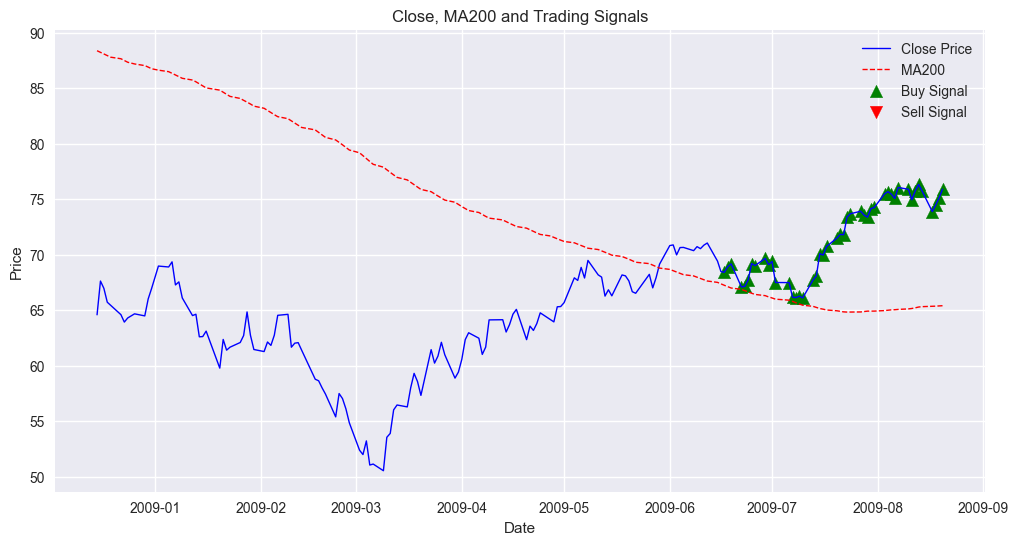

In [144]:
def plot_bear_signal(bear_signal):
    plt.figure(figsize=(12, 6))


    plt.plot(bear_signal.index, 
             bear_signal['Close'], 
             label='Close Price', 
             color='blue', 
             linewidth=1)


    plt.plot(bear_signal.index, 
             bear_signal['MA200'], 
             label='MA200', 
             color='red', 
             linestyle='--', 
             linewidth=1)


    buy_signals = bear_signal[bear_signal['signal'] == 1]
    plt.scatter(buy_signals.index, 
                buy_signals['Close'], 
                marker='^', 
                color='green', 
                s=80, 
                label='Buy Signal')


    sell_signals = bear_signal[bear_signal['signal'] == -1]
    plt.scatter(sell_signals.index, 
                sell_signals['Close'], 
                marker='v', 
                color='red', 
                s=80, 
                label='Sell Signal')

    plt.title('Close, MA200 and Trading Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_bear_signal(bear_signal)


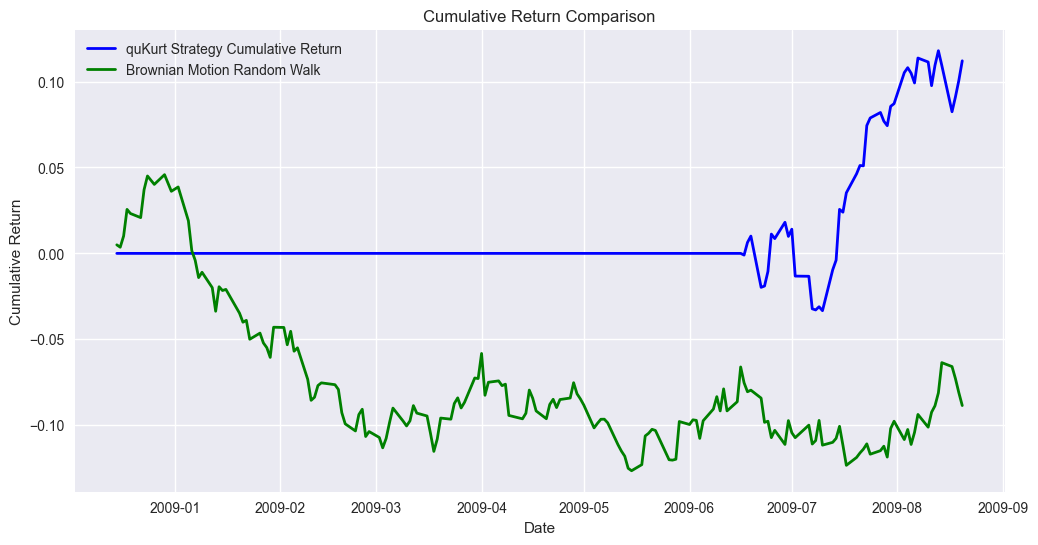

In [141]:
def plot_cumulative_returns_vs_random_walk(bear_signal):
    strategy_log_ret = bear_signal['signal'] * bear_signal['log_Return']
    
    strategy_cum_log_ret = strategy_log_ret.cumsum()
    strategy_cum_ret = np.exp(strategy_cum_log_ret) - 1

    n = len(bear_signal)
    np.random.seed(42)  
    random_log_returns = np.random.normal(loc=0.0, scale=0.01, size=n)
    

    random_cum_log_ret = np.cumsum(random_log_returns)

    random_cum_ret = np.exp(random_cum_log_ret) - 1


    plt.figure(figsize=(12, 6))


    plt.plot(bear_signal.index, strategy_cum_ret, 
             label='quKurt Strategy Cumulative Return', color='blue', linewidth=2)

    plt.plot(bear_signal.index, random_cum_ret, 
             label='Brownian Motion Random Walk', color='green', linewidth=2)

    plt.title('Cumulative Return Comparison')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_cumulative_returns_vs_random_walk(bear_signal)

In [138]:
valid_data = bear_signal.dropna()

valid_data['Market_Return'] = bear_signal['Close'].pct_change()

valid_data['Trade_Signal'] = bear_signal['signal'].shift(1)

valid_data = valid_data.fillna(0)
valid_data



Price,Close,High,Low,Open,Volume,log_Return,MA200,RollingMax,RollingMin,Drawdown,Rally,Market_State,quKurt,theta_hat,n,kappa_L,kappa_U,signal,Market_Return,Trade_Signal
Date,,,,,,,,,,,,,,,,,,,,
2008-12-15,64.577881,65.608184,63.503423,65.512510,256694200,-0.013934,88.367275,108.343979,55.525921,-0.403955,0.163022,bear,0.000000,0.0,1,-2.000000,2.000000,0,0.000000,0.0
2008-12-16,67.617249,67.720278,64.894310,67.617249,377699500,0.047065,88.223627,108.343979,55.525921,-0.375902,0.217760,bear,0.000000,0.0,2,-1.414214,1.414214,0,0.047065,0.0
2008-12-17,66.962280,68.022021,66.277865,66.851890,281819800,-0.009686,88.073661,108.343979,55.525921,-0.381947,0.205964,bear,0.000000,0.0,3,-1.154701,1.154701,0,-0.009686,0.0
2008-12-18,65.711220,67.462732,64.916414,67.264033,374673300,-0.018683,87.927474,108.343979,55.525921,-0.393494,0.183433,bear,0.000000,0.0,4,-1.000000,1.000000,0,-0.018683,0.0
2008-12-19,65.428551,67.231379,65.354356,66.103681,301451300,-0.004302,87.784764,108.343979,55.525921,-0.396103,0.178342,bear,0.000000,0.0,5,-0.894427,0.894427,0,-0.004302,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-08-14,75.737190,76.345851,74.918123,76.285735,199616100,-0.007679,65.311489,95.259354,50.531105,-0.204937,0.498823,bear,4.210524,0.0,168,-0.154303,0.154303,1,-0.007679,1.0
2009-08-17,73.873604,74.354522,73.723319,74.279380,237667500,-0.024606,65.338355,95.259354,50.531105,-0.224500,0.461943,bear,4.234758,0.0,169,-0.153846,0.153846,1,-0.024606,1.0
2009-08-18,74.459717,74.722724,73.903656,74.038915,173461500,0.007934,65.356303,95.259354,50.531105,-0.218347,0.473542,bear,3.990046,0.0,170,-0.153393,0.153393,1,0.007934,1.0


In [140]:
valid_data['Position_Change'] = valid_data['Trade_Signal'].diff().abs()

transaction_cost = 0.001

valid_data['Strategy_Return'] = valid_data['Trade_Signal'] * valid_data['Market_Return'] - transaction_cost * valid_data['Position_Change']

valid_data['Cumulative_Market'] = (1 + valid_data['Market_Return'].fillna(0)).cumprod()
valid_data['Cumulative_Strategy'] = (1 + valid_data['Strategy_Return'].fillna(0)).cumprod()

total_days = (valid_data.index[-1] - valid_data.index[0]).days
annual_return_strategy = (valid_data['Cumulative_Strategy'].iloc[-1] ** (365 / total_days)) - 1
annual_return_market = (valid_data['Cumulative_Market'].iloc[-1] ** (365 / total_days)) - 1


daily_vol_strategy = valid_data['Strategy_Return'].std()
annual_vol_strategy = daily_vol_strategy * np.sqrt(252)  

daily_vol_market = valid_data['Market_Return'].std()  
annual_vol_market = daily_vol_market * np.sqrt(252)

sharpe_ratio_strategy = annual_return_strategy / annual_vol_strategy
sharpe_ratio_market = annual_return_market / annual_vol_market


cumulative_returns_strategy = valid_data['Cumulative_Strategy']
running_max_strategy = cumulative_returns_strategy.cummax()
drawdown_strategy = (cumulative_returns_strategy - running_max_strategy) / running_max_strategy
max_drawdown_strategy = drawdown_strategy.min()

cumulative_returns_market = valid_data['Cumulative_Market']
running_max_market = cumulative_returns_market.cummax()
drawdown_market = (cumulative_returns_market - running_max_market) / running_max_market
max_drawdown_market = drawdown_market.min()


print(f"Date Length: {valid_data.index[0].date()} to {valid_data.index[-1].date()}")
print(f"Total tday: {len(valid_data)}")
print("\n--- Strategy statistics ---")
print(f"Annual Return: {annual_return_strategy:.2%}")
print(f"Annual Volatlity: {annual_vol_strategy:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_strategy:.2f}")
print(f"MDD: {max_drawdown_strategy:.2%}")
print("\n--- Benchmark Testing (Buy & Hold) ---")
print(f"Annual Return: {annual_return_market:.2%}")
print(f"Annual Volatility: {annual_vol_market:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_market:.2f}")
print(f"MDD: {max_drawdown_market:.2%}")


Date Length: 2008-12-15 to 2009-08-20
Total tday: 172

--- Strategy statistics ---
Annual Return: 16.33%
Annual Volatlity: 10.08%
Sharpe Ratio: 1.62
MDD: -5.11%

--- Benchmark Testing (Buy & Hold) ---
Annual Return: 26.81%
Annual Volatility: 31.08%
Sharpe Ratio: 0.86
MDD: -27.13%


## Normal Market Apply

In [142]:
normal_with_qukurt["theta_hat"] = (
    normal_with_qukurt["quKurt"]
    .rolling(window=126, min_periods=126)
    .mean()
)
normal_with_qukurt= normal_with_qukurt.fillna(0)
normal_with_qukurt["n"] = np.arange(len(normal_with_qukurt)) + 1

normal_with_qukurt

Price,Close,High,Low,Open,Volume,log_Return,MA200,RollingMax,RollingMin,Drawdown,Rally,Market_State,quKurt,theta_hat,n
Date,,,,,,,,,,,,,,,
2005-03-15,82.454483,83.360425,82.413306,83.332972,62438500,0.000000,0.000000,82.454483,82.454483,0.000000,0.000000,normal,0.000000,0.000000,1
2005-03-16,81.754471,82.468245,81.603480,82.152533,74874200,-0.008490,0.000000,82.454483,81.754471,-0.008490,0.000000,normal,0.000000,0.000000,2
2005-03-17,81.919136,82.179936,81.658336,81.884818,62584200,0.002014,0.000000,82.454483,81.754471,-0.006493,0.002014,normal,0.000000,0.000000,3
2005-03-18,81.675957,82.358081,81.407241,82.068696,60232000,-0.002969,0.000000,82.454483,81.675957,-0.009442,0.000000,normal,0.000000,0.000000,4
2005-03-21,81.372757,81.841288,81.138494,81.793057,61244300,-0.003712,0.000000,82.454483,81.372757,-0.013119,0.000000,normal,0.000000,0.000000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-20,266.403473,268.488112,266.274919,267.946290,51596400,-0.007662,255.162311,277.350159,213.224777,-0.039469,0.249402,normal,4.193499,4.235981,1846
2019-08-21,268.570740,268.947238,267.900336,268.598289,49524700,0.008135,255.268062,277.350159,213.224777,-0.031655,0.259566,normal,4.173506,4.231801,1847
2019-08-22,268.488190,269.930003,266.688236,269.287176,51666400,-0.000307,255.380728,277.350159,213.224777,-0.031952,0.259179,normal,4.135422,4.227318,1848


In [143]:
normal_signal = apply_kappa_thresholds(
    normal_with_qukurt,
    qukurt_col="quKurt", 
    theta_col="theta_hat",
    q_lower=-2.0,   # example stand-ins for q_{\alpha/2}^*, q_{1-\alpha/2}^*
    q_upper=+2.0,
    alpha=0.05
)
normal_signal

Price,Close,High,Low,Open,Volume,log_Return,MA200,RollingMax,RollingMin,Drawdown,Rally,Market_State,quKurt,theta_hat,n,kappa_L,kappa_U,signal
Date,,,,,,,,,,,,,,,,,,
2005-03-15,82.454483,83.360425,82.413306,83.332972,62438500,0.000000,0.000000,82.454483,82.454483,0.000000,0.000000,normal,0.000000,0.000000,1,-2.000000,2.000000,0
2005-03-16,81.754471,82.468245,81.603480,82.152533,74874200,-0.008490,0.000000,82.454483,81.754471,-0.008490,0.000000,normal,0.000000,0.000000,2,-1.414214,1.414214,0
2005-03-17,81.919136,82.179936,81.658336,81.884818,62584200,0.002014,0.000000,82.454483,81.754471,-0.006493,0.002014,normal,0.000000,0.000000,3,-1.154701,1.154701,0
2005-03-18,81.675957,82.358081,81.407241,82.068696,60232000,-0.002969,0.000000,82.454483,81.675957,-0.009442,0.000000,normal,0.000000,0.000000,4,-1.000000,1.000000,0
2005-03-21,81.372757,81.841288,81.138494,81.793057,61244300,-0.003712,0.000000,82.454483,81.372757,-0.013119,0.000000,normal,0.000000,0.000000,5,-0.894427,0.894427,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-20,266.403473,268.488112,266.274919,267.946290,51596400,-0.007662,255.162311,277.350159,213.224777,-0.039469,0.249402,normal,4.193499,4.235981,1846,4.189432,4.282531,0
2019-08-21,268.570740,268.947238,267.900336,268.598289,49524700,0.008135,255.268062,277.350159,213.224777,-0.031655,0.259566,normal,4.173506,4.231801,1847,4.185264,4.278338,-1
2019-08-22,268.488190,269.930003,266.688236,269.287176,51666400,-0.000307,255.380728,277.350159,213.224777,-0.031952,0.259179,normal,4.135422,4.227318,1848,4.180794,4.273842,-1


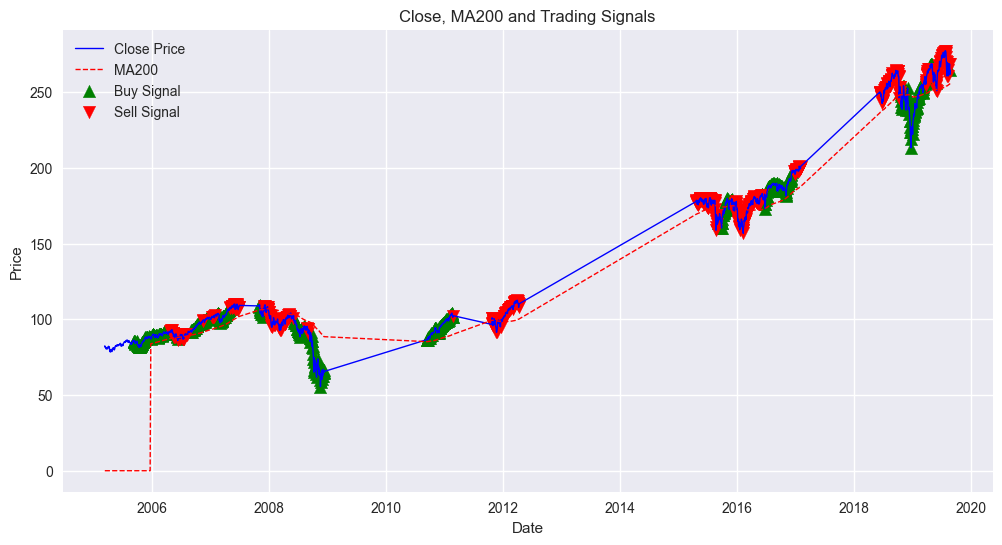

In [145]:
def plot_normal_signal(normal_signal):
    plt.figure(figsize=(12, 6))


    plt.plot(normal_signal.index, 
             normal_signal['Close'], 
             label='Close Price', 
             color='blue', 
             linewidth=1)


    plt.plot(normal_signal.index, 
             normal_signal['MA200'], 
             label='MA200', 
             color='red', 
             linestyle='--', 
             linewidth=1)


    buy_signals = normal_signal[normal_signal['signal'] == 1]
    plt.scatter(buy_signals.index, 
                buy_signals['Close'], 
                marker='^', 
                color='green', 
                s=80, 
                label='Buy Signal')


    sell_signals = normal_signal[normal_signal['signal'] == -1]
    plt.scatter(sell_signals.index, 
                sell_signals['Close'], 
                marker='v', 
                color='red', 
                s=80, 
                label='Sell Signal')

    plt.title('Close, MA200 and Trading Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_normal_signal(normal_signal)


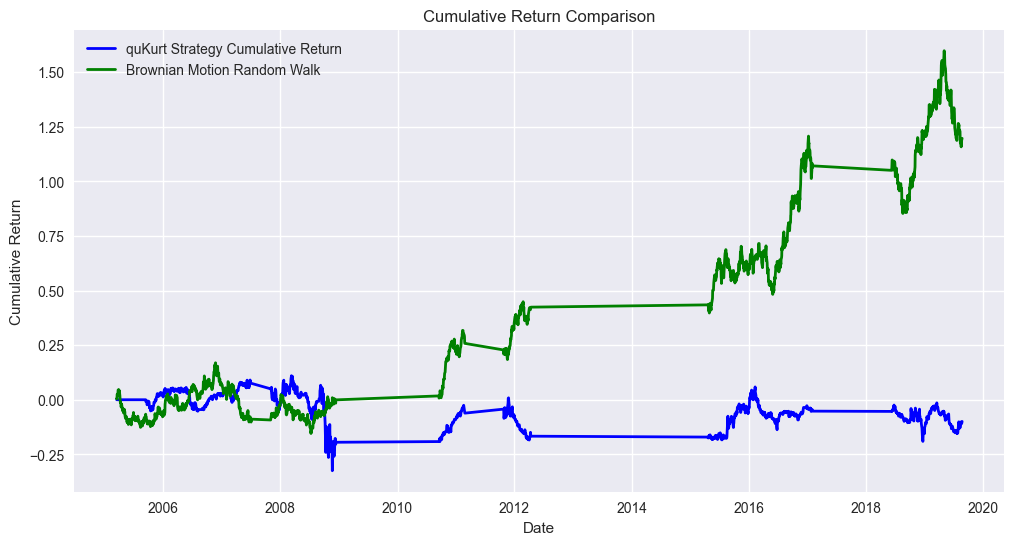

In [149]:
def plot_cumulative_returns_vs_random_walk(normal_signal):
    strategy_log_ret = normal_signal['signal'] * normal_signal['log_Return']
    
    strategy_cum_log_ret = strategy_log_ret.cumsum()
    strategy_cum_ret = np.exp(strategy_cum_log_ret) - 1

    n = len(normal_signal)
    np.random.seed(42)  
    random_log_returns = np.random.normal(loc=0.0, scale=0.01, size=n)
    

    random_cum_log_ret = np.cumsum(random_log_returns)

    random_cum_ret = np.exp(random_cum_log_ret) - 1


    plt.figure(figsize=(12, 6))


    plt.plot(normal_signal.index, strategy_cum_ret, 
             label='quKurt Strategy Cumulative Return', color='blue', linewidth=2)

    plt.plot(normal_signal.index, random_cum_ret, 
             label='Brownian Motion Random Walk', color='green', linewidth=2)

    plt.title('Cumulative Return Comparison')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_cumulative_returns_vs_random_walk(normal_signal)

In [146]:
valid_data = normal_signal.dropna()

valid_data['Market_Return'] = normal_signal['Close'].pct_change()

valid_data['Trade_Signal'] = normal_signal['signal'].shift(1)

valid_data = valid_data.fillna(0)
valid_data



Price,Close,High,Low,Open,Volume,log_Return,MA200,RollingMax,RollingMin,Drawdown,Rally,Market_State,quKurt,theta_hat,n,kappa_L,kappa_U,signal,Market_Return,Trade_Signal
Date,,,,,,,,,,,,,,,,,,,,
2005-03-15,82.454483,83.360425,82.413306,83.332972,62438500,0.000000,0.000000,82.454483,82.454483,0.000000,0.000000,normal,0.000000,0.000000,1,-2.000000,2.000000,0,0.000000,0.0
2005-03-16,81.754471,82.468245,81.603480,82.152533,74874200,-0.008490,0.000000,82.454483,81.754471,-0.008490,0.000000,normal,0.000000,0.000000,2,-1.414214,1.414214,0,-0.008490,0.0
2005-03-17,81.919136,82.179936,81.658336,81.884818,62584200,0.002014,0.000000,82.454483,81.754471,-0.006493,0.002014,normal,0.000000,0.000000,3,-1.154701,1.154701,0,0.002014,0.0
2005-03-18,81.675957,82.358081,81.407241,82.068696,60232000,-0.002969,0.000000,82.454483,81.675957,-0.009442,0.000000,normal,0.000000,0.000000,4,-1.000000,1.000000,0,-0.002969,0.0
2005-03-21,81.372757,81.841288,81.138494,81.793057,61244300,-0.003712,0.000000,82.454483,81.372757,-0.013119,0.000000,normal,0.000000,0.000000,5,-0.894427,0.894427,0,-0.003712,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-20,266.403473,268.488112,266.274919,267.946290,51596400,-0.007662,255.162311,277.350159,213.224777,-0.039469,0.249402,normal,4.193499,4.235981,1846,4.189432,4.282531,0,-0.007662,0.0
2019-08-21,268.570740,268.947238,267.900336,268.598289,49524700,0.008135,255.268062,277.350159,213.224777,-0.031655,0.259566,normal,4.173506,4.231801,1847,4.185264,4.278338,-1,0.008135,0.0
2019-08-22,268.488190,269.930003,266.688236,269.287176,51666400,-0.000307,255.380728,277.350159,213.224777,-0.031952,0.259179,normal,4.135422,4.227318,1848,4.180794,4.273842,-1,-0.000307,-1.0


In [147]:
valid_data['Position_Change'] = valid_data['Trade_Signal'].diff().abs()

transaction_cost = 0.001

valid_data['Strategy_Return'] = valid_data['Trade_Signal'] * valid_data['Market_Return'] - transaction_cost * valid_data['Position_Change']

valid_data['Cumulative_Market'] = (1 + valid_data['Market_Return'].fillna(0)).cumprod()
valid_data['Cumulative_Strategy'] = (1 + valid_data['Strategy_Return'].fillna(0)).cumprod()

total_days = (valid_data.index[-1] - valid_data.index[0]).days
annual_return_strategy = (valid_data['Cumulative_Strategy'].iloc[-1] ** (365 / total_days)) - 1
annual_return_market = (valid_data['Cumulative_Market'].iloc[-1] ** (365 / total_days)) - 1


daily_vol_strategy = valid_data['Strategy_Return'].std()
annual_vol_strategy = daily_vol_strategy * np.sqrt(252)  

daily_vol_market = valid_data['Market_Return'].std()  
annual_vol_market = daily_vol_market * np.sqrt(252)

sharpe_ratio_strategy = annual_return_strategy / annual_vol_strategy
sharpe_ratio_market = annual_return_market / annual_vol_market


cumulative_returns_strategy = valid_data['Cumulative_Strategy']
running_max_strategy = cumulative_returns_strategy.cummax()
drawdown_strategy = (cumulative_returns_strategy - running_max_strategy) / running_max_strategy
max_drawdown_strategy = drawdown_strategy.min()

cumulative_returns_market = valid_data['Cumulative_Market']
running_max_market = cumulative_returns_market.cummax()
drawdown_market = (cumulative_returns_market - running_max_market) / running_max_market
max_drawdown_market = drawdown_market.min()


print(f"Date Length: {valid_data.index[0].date()} to {valid_data.index[-1].date()}")
print(f"Total tday: {len(valid_data)}")
print("\n--- Strategy statistics ---")
print(f"Annual Return: {annual_return_strategy:.2%}")
print(f"Annual Volatlity: {annual_vol_strategy:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_strategy:.2f}")
print(f"MDD: {max_drawdown_strategy:.2%}")
print("\n--- Benchmark Testing (Buy & Hold) ---")
print(f"Annual Return: {annual_return_market:.2%}")
print(f"Annual Volatility: {annual_vol_market:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_market:.2f}")
print(f"MDD: {max_drawdown_market:.2%}")


Date Length: 2005-03-15 to 2019-08-26
Total tday: 1850

--- Strategy statistics ---
Annual Return: -8.26%
Annual Volatlity: 33.35%
Sharpe Ratio: -0.25
MDD: -78.65%

--- Benchmark Testing (Buy & Hold) ---
Annual Return: 8.40%
Annual Volatility: 33.61%
Sharpe Ratio: 0.25
MDD: -49.55%


# Signal Optimization

In [158]:
def backtest_with_thresholds(
    df: pd.DataFrame,
    kappa_l: float,
    kappa_u: float
) -> float:
    """
    1) Generate signals based on quKurt:
         signal = +1 if quKurt > kappa_u
                  -1 if quKurt < kappa_l
                   0 otherwise
    2) Compute daily PnL = signal(t-1) * Returns(t)
    3) Return Sharpe ratio as the performance metric
    
    Args:
        df: must contain ["quKurt", "Returns"].
        kappa_l, kappa_u: thresholds to trigger short/long signals.
    
    Returns:
        float: The Sharpe ratio of the strategy over the period.
    """
    # Copy to avoid mutating original
    temp = df.copy()
    
    # 1) Create signals
    temp['signal'] = 0
    temp.loc[temp['quKurt'] > kappa_u, 'signal'] = +1
    temp.loc[temp['quKurt'] < kappa_l, 'signal'] = -1
    
    # 2) Shift signal by 1 bar to simulate we hold that position
    #    through the next day's return
    temp['signal_shifted'] = temp['signal'].shift(1).fillna(0)
    
    # daily PnL
    temp['pnl'] = temp['signal_shifted'] * temp['log_Return']
    
    # 3) Sharpe ratio
    avg_pnl = temp['pnl'].mean()
    std_pnl = temp['pnl'].std()
    if std_pnl == 0:
        return -999  # or 0, or some penalty
    
    sharpe = avg_pnl / std_pnl
    return sharpe


In [159]:
def grid_search_thresholds(
    df: pd.DataFrame,
    kappa_l_candidates,
    kappa_u_candidates
):
    """
    A simple grid search over arrays of kappa_l and kappa_u, 
    returning the best pair (and the best Sharpe ratio).
    """
    best_sharpe = -999
    best_params = (None, None)
    
    for kl in kappa_l_candidates:
        for ku in kappa_u_candidates:
            if ku <= kl:
                continue  # skip invalid region
            sr = backtest_with_thresholds(df, kl, ku)
            if sr > best_sharpe:
                best_sharpe = sr
                best_params = (kl, ku)
    
    return best_params, best_sharpe

# Example usage with some candidate ranges:
kappa_l_space = np.linspace(0.0, 1.0, 6)   # 0.0, 0.2, 0.4, 0.6, 0.8, 1.0
kappa_u_space = np.linspace(1.0, 3.0, 6)   # 1.0, 1.4, 1.8, 2.2, 2.6, 3.0

best_kl, best_ku = None, None
best_sr = -999

best_params_gs, best_sr_gs = grid_search_thresholds(
    bear_signal,
    kappa_l_space,
    kappa_u_space
)

print(f"Grid Search => Best (kappa_L, kappa_U) = {best_params_gs}, Sharpe={best_sr_gs:.3f}")


Grid Search => Best (kappa_L, kappa_U) = (0.0, 1.0), Sharpe=0.098


In [ ]:
import random

def ga_optimize_thresholds(
    df: pd.DataFrame,
    pop_size=20,
    n_generations=10,
    kl_bounds=(0.0, 1.0),
    ku_bounds=(1.0, 3.0),
    mutation_prob=0.2,
    crossover_prob=0.5
):
    """
    A minimal genetic algorithm to find (kappa_L, kappa_U) that maximizes Sharpe.
    We keep a population of (kl, ku) pairs, evolve over generations.
    
    Args:
        df (pd.DataFrame): must contain quKurt, Returns
        pop_size (int): how many individuals in each generation
        n_generations (int): how many generations to run
        kl_bounds, ku_bounds: the numeric range for each param
        mutation_prob, crossover_prob: probabilities for GA ops
    
    Returns:
        (best_kl, best_ku, best_sharpe)
    """
    # 1) Randomly initialize population
    def random_individual():
        kl = random.uniform(*kl_bounds)
        ku = random.uniform(*ku_bounds)
        # ensure kl < ku, otherwise swap
        if kl >= ku:
            kl, ku = ku, kl
        return (kl, ku)
    
    population = [random_individual() for _ in range(pop_size)]
    
    def fitness(ind):
        (kl, ku) = ind
        if ku <= kl:
            return -9999
        return backtest_with_thresholds(df, kl, ku)
    
    # 2) Evolve over generations
    best_ind = None
    best_fit = -9999
    
    for gen in range(n_generations):
        # Evaluate fitness
        fits = [fitness(ind) for ind in population]
        
        # Track best
        for ind, f in zip(population, fits):
            if f > best_fit:
                best_fit = f
                best_ind = ind
        
        # 3) Selection (simple top half selection)
        sorted_pop = [x for _, x in sorted(zip(fits, population), key=lambda tup: tup[0], reverse=True)]
        survivors = sorted_pop[: pop_size // 2]
        
        # 4) Reproduction
        new_population = survivors.copy()
        
        # Crossover
        while len(new_population) < pop_size:
            if random.random() < crossover_prob and len(survivors) >= 2:
                # pick 2 parents
                p1, p2 = random.sample(survivors, 2)
                kl1, ku1 = p1
                kl2, ku2 = p2
                # single-point crossover
                child1 = (kl1, ku2)
                child2 = (kl2, ku1)
                new_population += [child1, child2]
            else:
                # or random new
                new_population.append(random_individual())
        
        # 5) Mutation
        for i in range(len(new_population)):
            if random.random() < mutation_prob:
                kl, ku = new_population[i]
                # small random mutation in kl or ku
                if random.random() < 0.5:
                    kl += random.uniform(-0.2, 0.2)
                else:
                    ku += random.uniform(-0.2, 0.2)
                # clamp to bounds
                kl = min(max(kl, kl_bounds[0]), kl_bounds[1])
                ku = min(max(ku, ku_bounds[0]), ku_bounds[1])
                # ensure kl < ku
                if kl >= ku:
                    kl, ku = ku, kl
                new_population[i] = (kl, ku)
        
        population = new_population
    
    return best_ind[0], best_ind[1], best_fit


# Example usage
best_kl_ga, best_ku_ga, best_sharpe_ga = ga_optimize_thresholds(
    bull_signal,
    pop_size=20,
    n_generations=10,
    kl_bounds=(0.0, 1.0),
    ku_bounds=(1.0, 3.0)
)



In [161]:
print(f"Genetic Algorithm => best kl={best_kl_ga:.3f}, best ku={best_ku_ga:.3f}, Sharpe={best_sharpe_ga:.3f}")

Genetic Algorithm => best kl=0.000, best ku=2.823, Sharpe=0.052


# Bear

[Bear] Fitted t-dist params => nu=50.000, loc=3.801, scale=0.336
 Final negative log-likelihood = 15.765


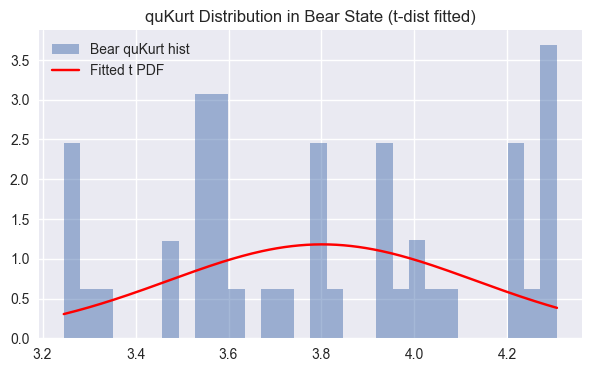

In [93]:
analyze_qukurt_tfit("Bear", bear_qk)

[Bear] => Fitted (df=4013819521963.066, loc=0.000, scale=3.816)


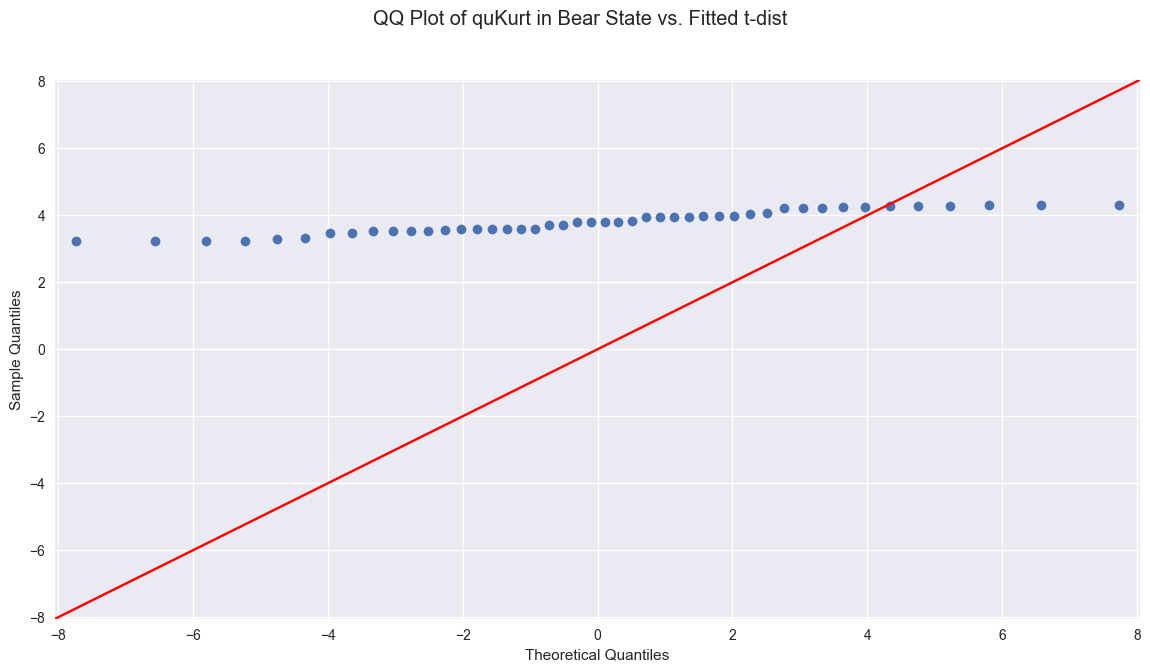

In [94]:
analyze_with_statsmodels("Bear", bear_qk)

In [95]:
model_bear = TDistModel(bear_qk)
results_bear = model_bear.fit(method='bfgs', disp=False)
print(results_bear.summary())

                              TDistModel Results                              
Dep. Variable:                      y   Log-Likelihood:                -15.493
Model:                     TDistModel   AIC:                             42.99
Method:            Maximum Likelihood   BIC:                             53.96
Date:                Fri, 14 Mar 2025                                         
Time:                        23:22:05                                         
No. Observations:                  46                                         
Df Residuals:                      43                                         
Df Model:                           3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
par0        2.328e+06   6.92e+08      0.003      0.997   -1.35e+09    1.36e+09
par1           3.8012      0.050     76.078      0.0

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: maxfun. After release 0.14, this will raise.
  warnings.warn(


In [96]:
# 3) Evaluate MSE, R^2
mse_bear, r2_bear = cdf_mse_r2(model_bear, results_bear)

print(f"== Bull State Model Fit ==")
print(f"  MSE (CDF) = {mse_bear:.6f}")
print(f"  R^2 (CDF) = {r2_bear:.3f}")

== Bull State Model Fit ==
  MSE (CDF) = 0.002923
  R^2 (CDF) = 0.963


# Normal 

[Normal] Fitted t-dist params => nu=2.685, loc=3.927, scale=0.652
 Final negative log-likelihood = 2396.322


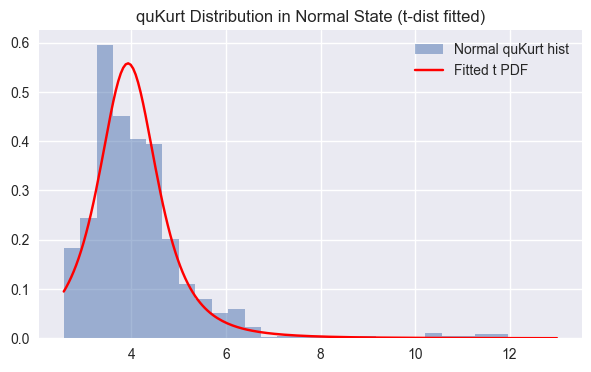

In [97]:
analyze_qukurt_tfit("Normal", normal_qk)

[Normal] => Fitted (df=2981787306469.672, loc=0.000, scale=4.372)


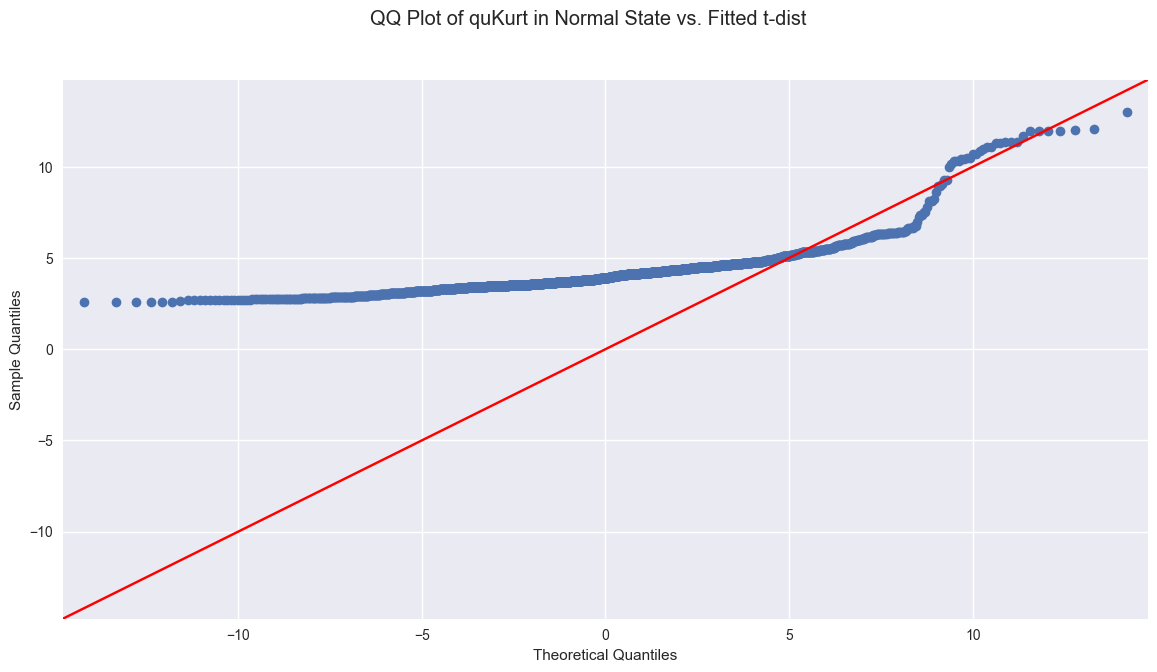

In [98]:
analyze_with_statsmodels("Normal", normal_qk)

In [99]:
model_normal = TDistModel(normal_qk)
results_normal = model_normal.fit(method='bfgs', disp=False)
print(results_normal.summary())

                              TDistModel Results                              
Dep. Variable:                      y   Log-Likelihood:                -2396.3
Model:                     TDistModel   AIC:                             4805.
Method:            Maximum Likelihood   BIC:                             4837.
Date:                Fri, 14 Mar 2025                                         
Time:                        23:37:40                                         
No. Observations:                1724                                         
Df Residuals:                    1721                                         
Df Model:                           3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
par0           2.6850      0.178     15.122      0.000       2.337       3.033
par1           3.9271      0.021    191.261      0.0

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: maxfun. After release 0.14, this will raise.
  warnings.warn(


In [100]:
# 3) Evaluate MSE, R^2
mse_normal, r2_normal = cdf_mse_r2(model_normal, results_normal)

print(f"== Bull State Model Fit ==")
print(f"  MSE (CDF) = {mse_normal:.6f}")
print(f"  R^2 (CDF) = {r2_normal:.3f}")

== Bull State Model Fit ==
  MSE (CDF) = 0.001358
  R^2 (CDF) = 0.984
